In [1]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib


In [137]:
# reload modules & set fname
importlib.reload(icrms)
importlib.reload(lcmsfns)

<module 'corems.lc_icpms_ftms.calc.lc_icrms_helpers' from '/Users/christiandewey/CoreMS/corems/lc_icpms_ftms/calc/lc_icrms_helpers.py'>

In [2]:
# get files & parsers

dir='/Volumes/Samsung_T5/NHMFL/2023_January_Christian/mzwindow/Zorbax_5um_inject_1500ms'
flist=os.listdir(dir)
os.chdir(dir)

# get parsers

MSfiles={}

for f in flist:
    if ('.raw' in f) & ('._' not in f):
        print(f)
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}

data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

data._raw_filelist = data.master_data_holder.keys()

20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_400_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_400_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_500_600_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_500_600_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_600_700_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_600_700_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_400_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_400_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_500_600_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_500_600_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_600_700_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough

In [17]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,3)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,1)
MSParameters.molecular_search.usedAtoms['Fe'] = (0,1)
#MSParameters.molecular_search.usedAtoms['S'] = (0,1)
#MSParameters.molecular_search.usedAtoms['P'] = (0,1)


fname = 'all_CHONCuFe.csv'

In [ ]:
# run assignment algorithm
timerange = [4,24]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref"

data.assign_formula(interval = interval, timerange = timerange, refmasslist = refmasslist, calorder =2, charge =1 , call_ppm_threshold = (0,2))

data_df = data.complete_results_df

In [19]:
# save assignment results as pd dataframe and export as .csv 

data_df.to_csv(dir+'/' +fname)


In [55]:

# add 'm/z window' and 'rep' columns
# reload modules & set fname
importlib.reload(icrms)
importlib.reload(lcmsfns)

data_df = pd.read_csv(dir+'/' +fname)
data_df = lcmsfns.add_mzwindow_col(data_df)

data_df = lcmsfns.addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())
print(data_df['m/z Window Size'].unique())

20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_400_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_400_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_500_600_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_500_600_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_600_700_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_600_700_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_fullmz_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_400_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_400_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_500_600_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_500_600_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_600_700_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough

In [56]:
importlib.reload(icrms)
importlib.reload(lcmsfns)

heter = ['N', 'Cu', 'Fe']
molclasses = lcmsfns.get_mol_class(heter)

molclasses

['CHO',
 'CHON',
 'CHONCu',
 'CHONFe',
 'CHOCu',
 'CHOCuFe',
 'CHOFe',
 'CHONCuFe',
 'Unassigned']

In [57]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
data_df = lcmsfns.assign_mol_class(data_df,molclasses)




time: 4
unassigned:  8345
assigned:  13249
	CHO: 5289
	CHON: 7711
	CHONCu: 18
	CHONFe: 114
	CHOCu: 23
	CHOCuFe: 34
	CHOFe: 9
	CHONCuFe: 51
	Unassigned: 8345

time: 6
unassigned:  7847
assigned:  15922
	CHO: 5661
	CHON: 9990
	CHONCu: 25
	CHONFe: 108
	CHOCu: 34
	CHOCuFe: 35
	CHOFe: 31
	CHONCuFe: 38
	Unassigned: 7847

time: 8
unassigned:  6986
assigned:  15745
	CHO: 5696
	CHON: 9757
	CHONCu: 23
	CHONFe: 119
	CHOCu: 40
	CHOCuFe: 35
	CHOFe: 8
	CHONCuFe: 67
	Unassigned: 6986

time: 10
unassigned:  13054
assigned:  32114
	CHO: 12902
	CHON: 18318
	CHONCu: 27
	CHONFe: 352
	CHOCu: 47
	CHOCuFe: 45
	CHOFe: 14
	CHONCuFe: 409
	Unassigned: 13054

time: 12
unassigned:  13099
assigned:  33638
	CHO: 14143
	CHON: 17745
	CHONCu: 83
	CHONFe: 268
	CHOCu: 47
	CHOCuFe: 54
	CHOFe: 46
	CHONCuFe: 1252
	Unassigned: 13099

time: 14
unassigned:  14457
assigned:  34810
	CHO: 15262
	CHON: 17606
	CHONCu: 86
	CHONFe: 275
	CHOCu: 51
	CHOCuFe: 45
	CHOFe: 22
	CHONCuFe: 1463
	Unassigned: 14457

time: 16
unassigned:  14033

In [58]:
# add column with blank file identity to use in blank subtraction

raw_filelist = data_df['file'].unique()

blank_files = [f for f in raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    #if 'fullmz' not in f:
        
    temp = data_df[data_df['file'] == f] 

    blank_data.append(temp)

blanks_df = pd.concat(blank_data)  # these are only 100 m/z blanks (200 m/z blanks were not collected)


print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())


data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window
    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]

     #  print(np.shape( btemp2['file']))

        temp2['blank file'] = btemp2['file'].iloc[0]
     #   print(np.shape( btemp2['file']))
        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2




['20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_fullmz_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_fullmz_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_400_500_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_400_500_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_600_700_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_600_700_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_500_600_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_500_600_02.raw']
['200-1200 m/z' '400-500 m/z' '600-700 m/z' '500-600 m/z']


In [59]:
# save assignment results as pd dataframe and export as .csv 
data_df.to_csv(dir+'/processed_'+fname)


In [60]:
#-#-#-# read assignment results from .csv
data_df = pd.read_csv(dir+'/processed_'+fname)

In [61]:
# create subsets of assignments based m/z window

list100mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mzfull = pd.concat(listfullzmz)


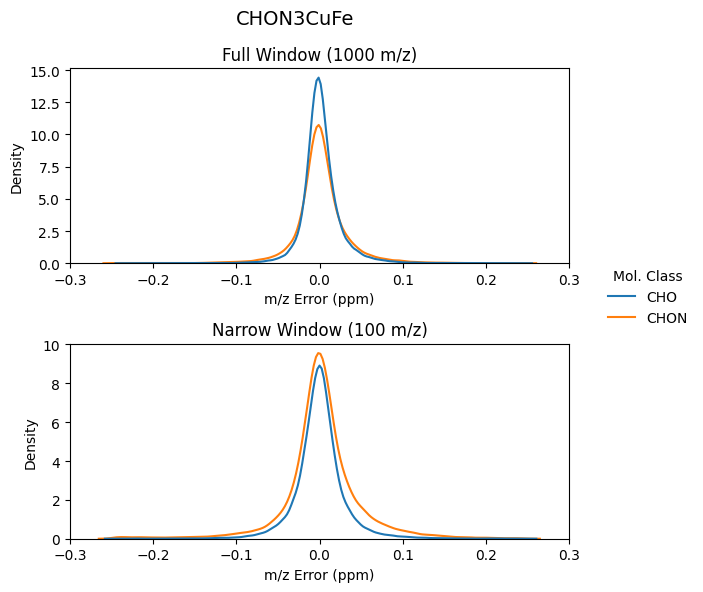

In [62]:
# plot assignment error kernel density CHON

ttt = 'CHON3CuFe'  ## title for main plot

dffull = mzfull[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

df100 = mz100[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)


fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


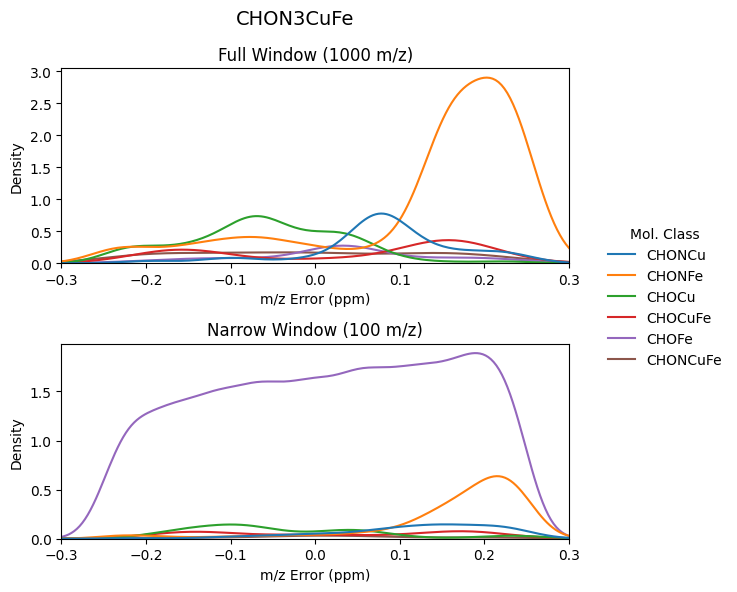

In [63]:
# plot assignment error kernel density CHON
import itertools
ttt = 'CHON3CuFe'  ## title for main plot

# set palette 
palette = itertools.cycle(sns.color_palette())



dffull = mzfull[(mzfull['mol_class']!='CHO') & (mzfull['mol_class']!='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1, palette=palette)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

palette = itertools.cycle(sns.color_palette())

df100 = mz100[(mz100['mol_class']!='CHO') & (mz100['mol_class']!='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False, palette=palette)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)

fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


In [64]:
# create subsets of assigned features 
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-700 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('\n200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

400-700 m/z, 100 m/z windowing: 
190518 features total; 127837 assigned (67.1%)

200-800 m/z window (full scan): 
193791 features total; 136910 assigned (70.6%)


In [65]:
# create subsets of unique features 
print('400-700 m/z, 100 m/z windowing:')
unique_100mz = lcmsfns.getUniqueFeatures(assigned_100mz)

print('\n200-800 m/z, 1000 m/z windowing:')
unique_fullmz = lcmsfns.getUniqueFeatures(assigned_fullmz)


400-700 m/z, 100 m/z windowing:

200-800 m/z, 1000 m/z windowing:


In [66]:
# subset assigned by m/z window between 400 and 700 m/z 
assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=400)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=700)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=700)]

mz100_456 = mz100[(mz100['m/z']>=400)]
mz100_456 = mz100_456[(mz100_456['m/z']<=700)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=700)]

print('400-700 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-700 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))


400-700 m/z, 100 m/z windowing: 
190518 features total
127837 assigned (67.1%)

400-700 m/z, full window: 
108026 features total
76351 assigned (70.7%)


In [67]:
print('400-700 m/z, 100 m/z windowing:')
unique_100mz_456 = lcmsfns.getUniqueFeatures(assigned_100mz_456)

print('\n400-700 m/z, 1000 m/z windowing:')
unique_fullmz_456 = lcmsfns.getUniqueFeatures(assigned_fullmz_456)

400-700 m/z, 100 m/z windowing:

400-700 m/z, 1000 m/z windowing:


['20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_fullmz_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_fullmz_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_fullmz_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_fullmz_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Spring_PPL_fullmz_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Spring_PPL_fullmz_02.raw'
 '20230115_LBA_Boiteau_Zorbax5um_1500IT_Spring_ENV_fullmz_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_fullmz_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_ENV_fullmz_02.raw'
 '20230115_LBA_Boiteau_Zorbax5um_1500IT_Spring_ENV_500_600_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Spring_PPL_500_600_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_500_600_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_qh2o_600_700_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_500_600_02.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_Slough_PPL_400_500_01.raw'
 '20230113_LBA_Boiteau

(0.0, 1000.0)

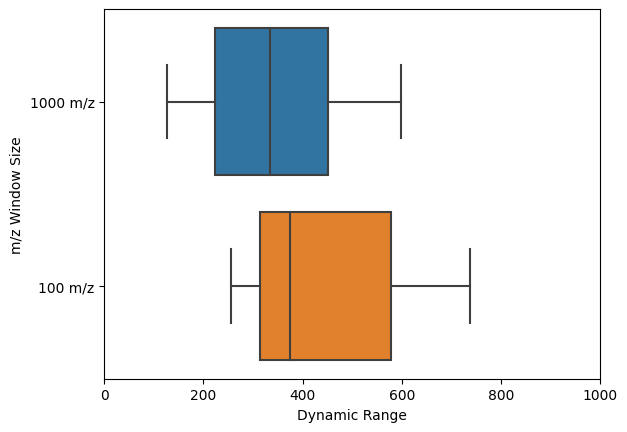

In [75]:
# plot dynamic range with box-whiskers plot

alldf = pd.concat([lcmsfns.blankSubtract(unique_fullmz_456, blnkthresh = 0.6), lcmsfns.blankSubtract(unique_100mz_456, blnkthresh = 0.6)])
alldf = pd.concat([unique_fullmz_456, unique_100mz_456])

for f in flist:
    if 'StdMix' in f:
        stdfile = f
alldf = alldf[alldf['file'] != stdfile]
print(alldf['file'].unique())
times = data_df['Time'].unique()

holder = {}
summary = []
summary2 = []

for mzw in alldf['m/z Window Size'].unique():
    
    sub1 = alldf[alldf['m/z Window Size'] == mzw]

    for t in times:
        
        print(mzw)
        lsh = {}
        lsh['m/z Window Size'] = mzw

        sub2 = sub1[sub1['Time'] == t]

        sub2 = sub2[sub2['S/N'] > 3]
        
        dynamic_range_t = max(sub2['Peak Height']/min(sub2['Peak Height']))
        
        lsh['Time'] = t
        lsh['Dynamic Range'] = dynamic_range_t        
        lsh['n Features'] = len(sub2)
        lsh['Max I'] = max(sub2['Peak Height'])
        
        lsh['Min I'] = min(sub2['Peak Height'])
        summary.append(lsh)


df=pd.DataFrame(summary)

sns.boxplot(data=df, x="Dynamic Range", y="m/z Window Size")

plt.xlim(0,1000)

In [155]:
import matplotlib.gridspec as gridspec

mz100_bs = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=400) & (mzfull_bs['Calibrated m/z']<=700)]
combo = pd.concat([mz100_bs, mzfull_bs_456], ignore_index=True)


for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z') or (w == '600-700 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

print(combo['m/z Window Size'].unique())


mzfull_456 = mzfull[(mzfull['Calibrated m/z']>=400) & (mzfull['Calibrated m/z']<=700)]
combo2 = pd.concat([mz100, mzfull_456], ignore_index=True)

for i in range(len(combo['m/z window'])):

    w = combo2['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z') or (w == '600-700 m/z'):
        
        combo2['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '200-1200 m/z'):
        
        combo2['m/z Window Size'].iloc[i] = '1000 m/z'

print(np.shape(combo),np.shape(combo2))



['100 m/z' '1000 m/z']
(42128, 81) (298544, 42)


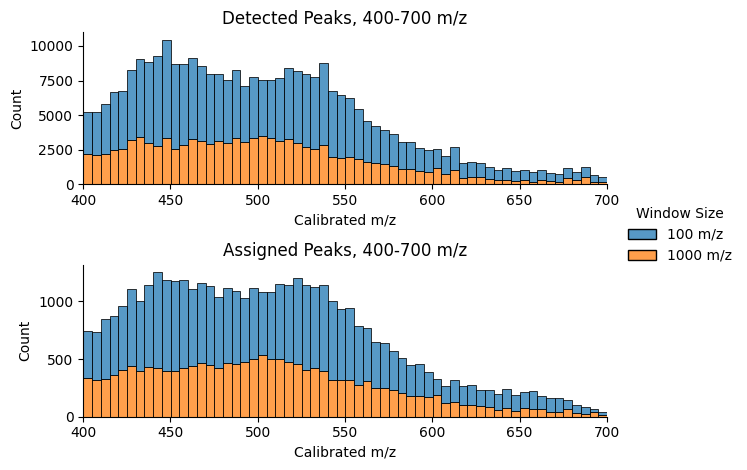

In [81]:

import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])


ax1 = plt.subplot(gs2[0])

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax1,binwidth=5)
ax1.set_ylabel('Count')
ax1.legend_.remove()
ax1.set_xlim(400,700)
ax1.set_title('Assigned Peaks, 400-700 m/z')
#ax1.set_ylim(0,4500)

sns.despine(ax=ax1)


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Count')
ax2.set_xlim(400,700)
#ax2.set_ylim(0,4500)
ax2.set_title('Detected Peaks, 400-700 m/z')
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

fig.tight_layout()
plt.show()

['CHO' 'CHON' 'CHONFe' 'CHOCu' 'CHOCuFe' 'CHONCuFe' 'Unassigned' 'CHONCu'
 'CHOFe']


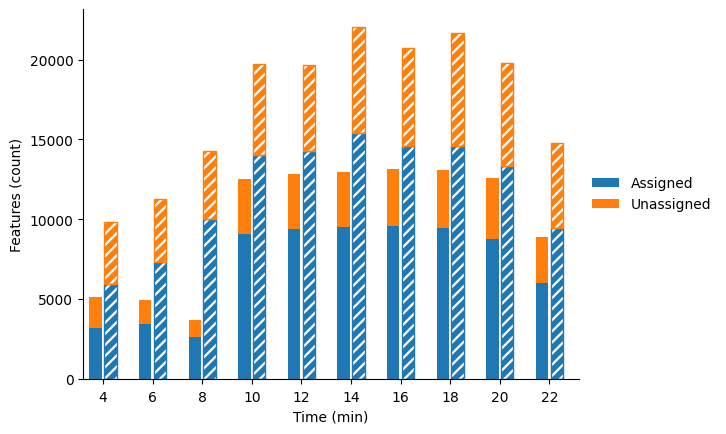

In [83]:
fig, ax4 = plt.subplots()

all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=600)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=600)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in all_results['mol_class'].unique():
            if mol_class == 'Unassigned':
                current['Unassigned']=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
            else:
                current['Assigned']=len(all_results[(all_results['mol_class']!='Unassigned') & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)

df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)

# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Features (count)')

ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine(ax=ax4)


plt.show()


['CHO' 'CHON' 'CHONFe' 'CHOCu' 'CHOCuFe' 'CHONCuFe' 'Unassigned' 'CHONCu'
 'CHOFe']


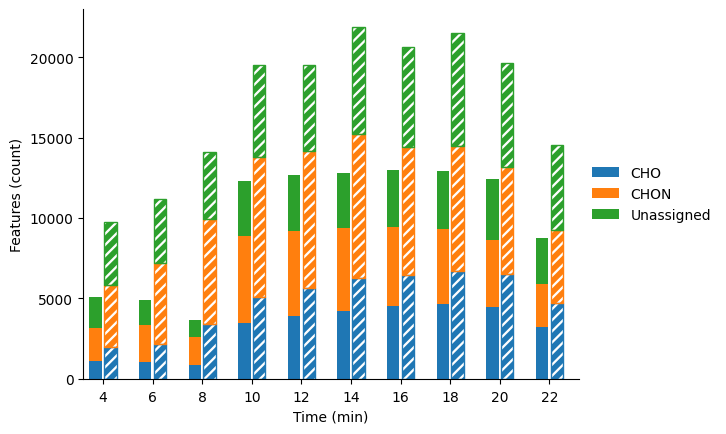

In [84]:
import matplotlib.patches as mpatches
fig, ax4 = plt.subplots()

all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=600)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=600)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHON', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Features (count)')

ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 400-700 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.
sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
sns.despine(ax=ax4)

plt.show()


['CHO' 'CHON' 'CHONFe' 'CHOCu' 'CHOCuFe' 'CHOFe' 'CHONCuFe' 'Unassigned'
 'CHONCu']


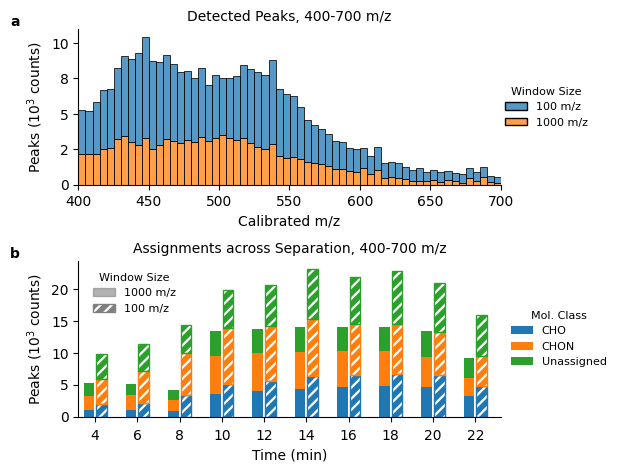

In [117]:

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])

plt.rcParams['legend.title_fontsize'] = 8


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Peaks ($10^3$ counts)')
ax2.set_xlim(400,700)
#ax2.set_ylim(0,4500)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.set_title('Detected Peaks, 400-700 m/z', fontsize = 10)
#ax2.legend_.remove()

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
fig = plt.gcf()

ax2.legend(handles, labels, bbox_to_anchor=(1.0, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})
ax2.text(-0.15, 1.05,'a',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax2.transAxes, fontweight='bold', fontsize = 10)

ax4 = plt.subplot(gs2[0])


all_results = pd.concat([mzfull[(mzfull['m/z']>=400) & (mzfull['m/z']<=700)],mz100[(mz100['m/z']>=400) & (mz100['m/z']<=700)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHON', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']
ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 20
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Peaks ($10^3$ counts)')

ax4.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, title='Mol. Class')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 400-700 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.
sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
fig = plt.gcf()
fig.tight_layout(pad = 1.)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(163, 72) (91, 55)
here


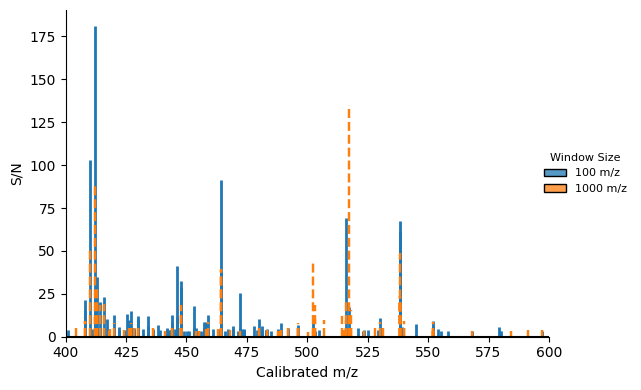

In [153]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec



fig, ax2 = plt.subplots(figsize = (6.5,4))

mz100_bs = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=400) & (mzfull_bs['Calibrated m/z']<=600)]

mz100_cu = mz100_bs[(mz100_bs['Calibrated m/z']>=400) & (mz100_bs['Calibrated m/z']<=600) ]
d1=lcmsfns.normMS(mz100_cu[mz100_cu['Cu']>0],mz100_cu[mz100_cu['Cu']>0])
d2=lcmsfns.normMS(mzfull_bs_456[mzfull_bs_456['Cu']>0],mzfull_bs_456[mzfull_bs_456['Cu']>0])

#d1=mz100_bs[mz100_bs['Cu']>0]
#d2=mzfull_bs_456[mzfull_bs_456['Cu']>0]
print(np.shape(d1),  np.shape(d2))

ax2 = lcmsfns.plot_ms(df1=d1,  df2=d2, start_mz=400, end_mz=600,ax_ms=ax2, norm=False)

sns.despine(ax=ax2)

ax2.set_xlim(400,600)
ax2.set_ylim(bottom=0)

print('here')

ax2.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})

plt.tight_layout()
plt.show()

(26044, 70)
(25610, 71)
[0 1 2 3]


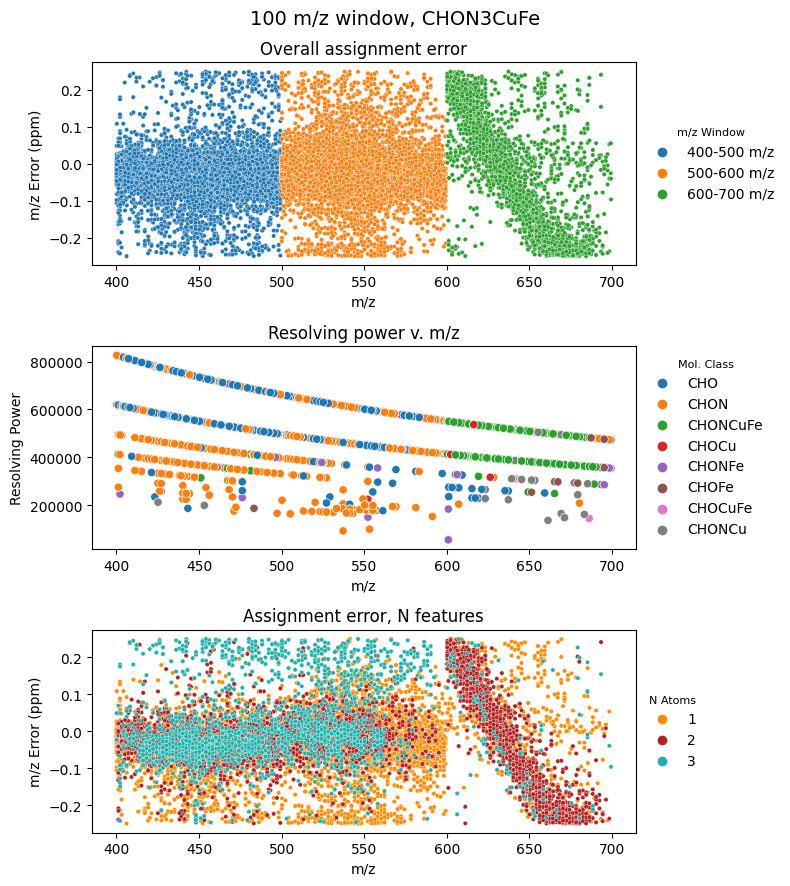

In [127]:
# 100 m/z window, error plots with blank substraction

importlib.reload(icrms)
importlib.reload(lcmsfns)
df = lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
print(np.shape(unique_100mz))
print(np.shape(df))
fig = lcmsfns.plotUnique(df,ps=10)

fig.suptitle('100 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()



In [140]:
# 100 m/z window, error plots with blank substraction

cu_features = data_df[(data_df['Cu']>0)]

cu_features = cu_features[(cu_features['m/z']<=600)& (cu_features['m/z']>=400)]
print(cu_features)

#410.151212

#data.master_data_holder['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'] #[file]={'parser': parser}

EICdic = {}
for mz,mf in zip(cu_features['m/z'],cu_features['Molecular Formula']):
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    EICdic[mf]=EIC[0][mz]

        Unnamed: 0.1  Unnamed: 0  Index         m/z  Calibrated m/z  \
13009         251381           2     30  540.158683      540.158683   
13010         252146           0     11  520.141867      520.141867   
13011         252148           2     34  540.158730      540.158730   
13014         335305         230    428  442.995977      442.996253   
13133           1722        1722   2532  538.162250      538.162220   
...              ...         ...    ...         ...             ...   
372333        246930        8392    946  539.165600      539.165550   
372335        252862         716     39  523.159308      523.159308   
372337        365824       12479    640  539.165218      539.165547   
372338        378494       11875    589  539.165190      539.165554   
372463        425798       13764    617  449.081787      449.082049   

        Calculated m/z  Peak Height  Peak Area  Resolving Power        S/N  \
13009       540.158613   102.782176  -0.114188    459296.658872  12.0

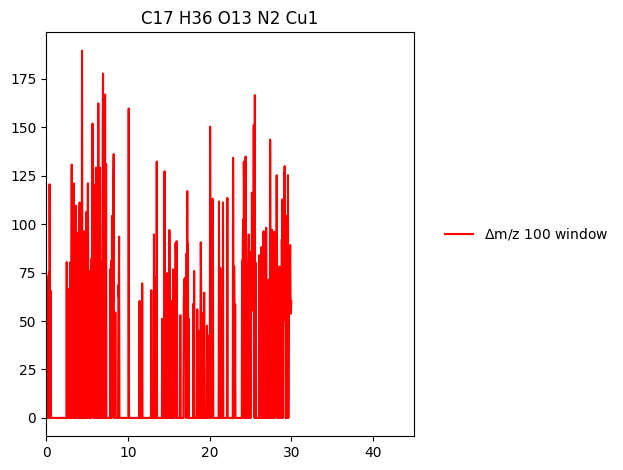

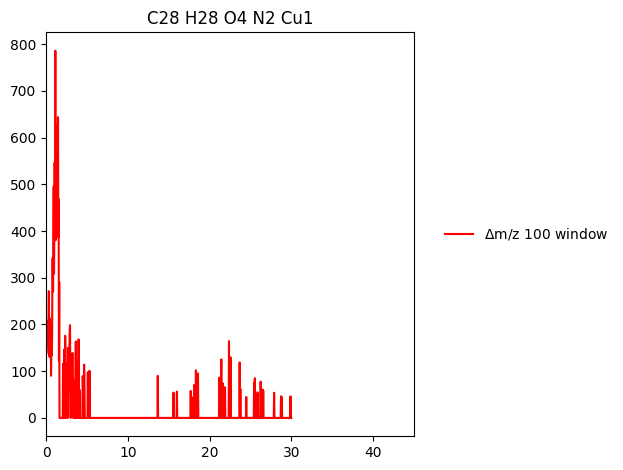

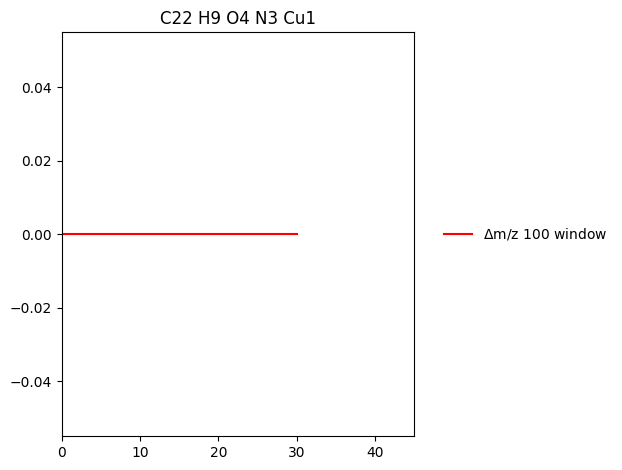

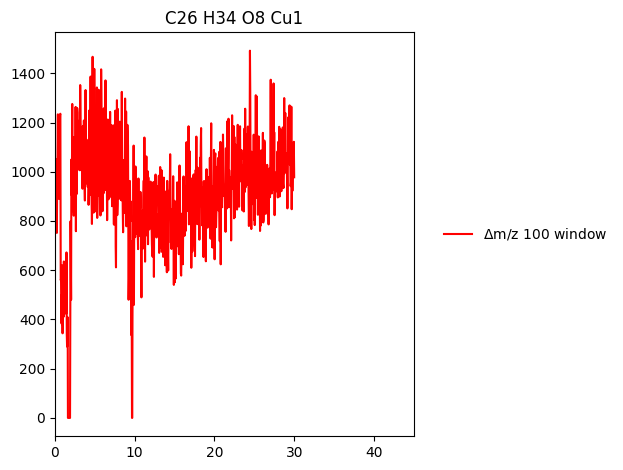

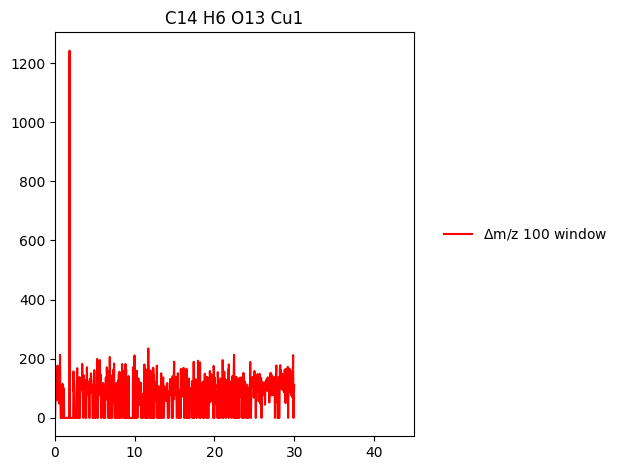

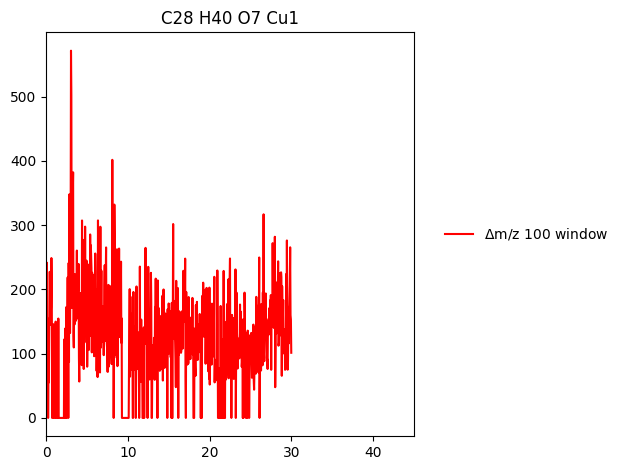

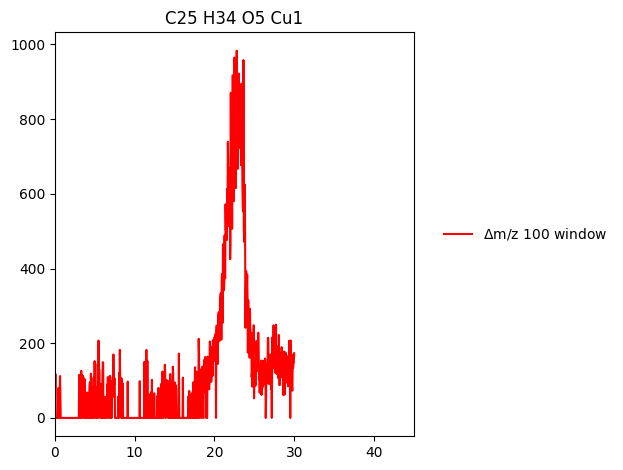

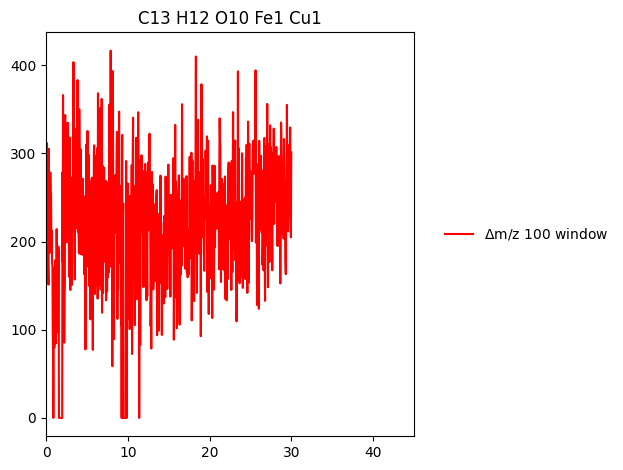

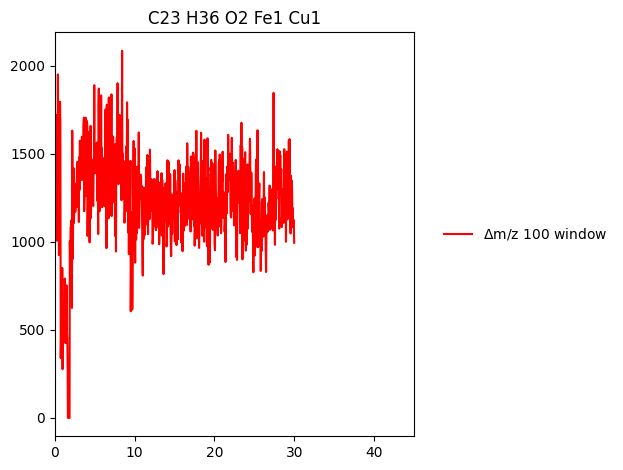

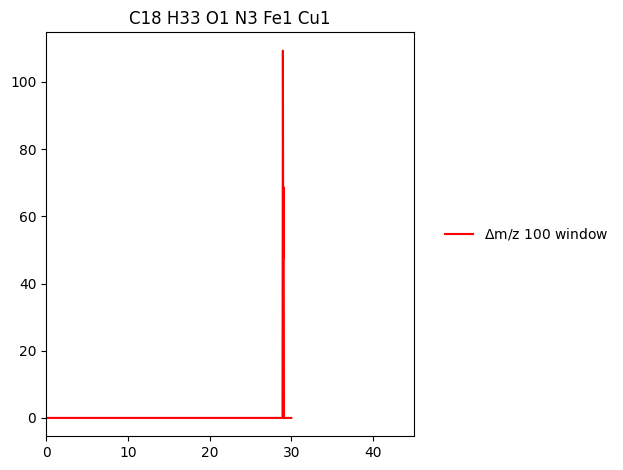

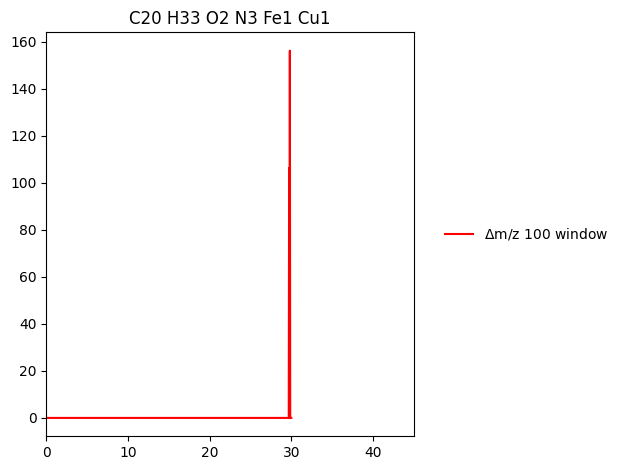

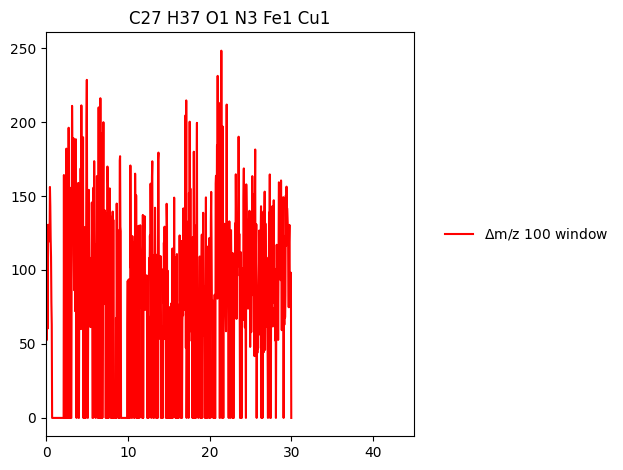

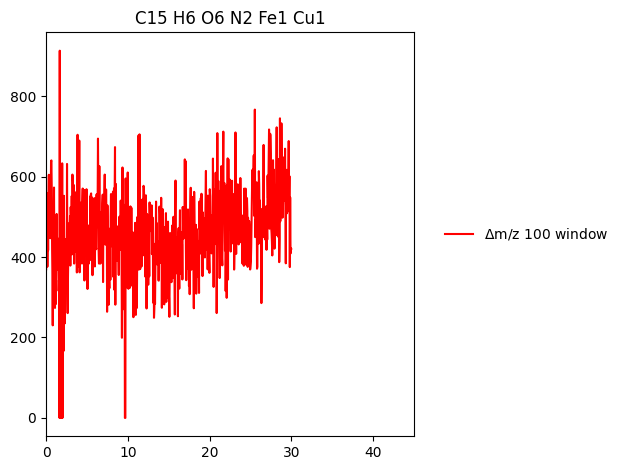

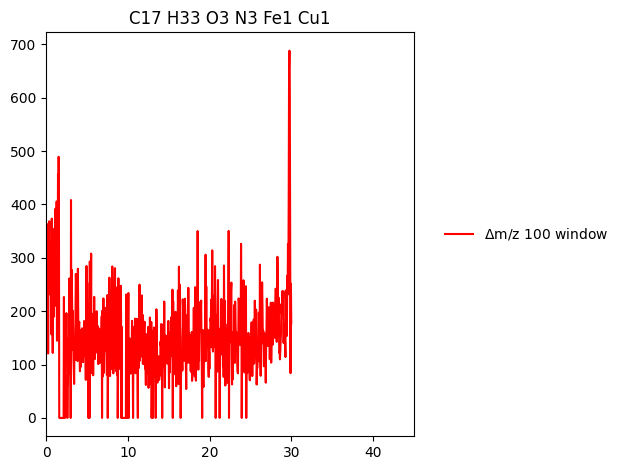

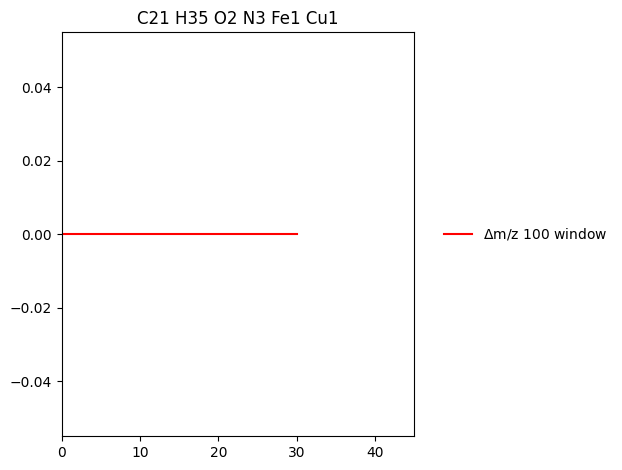

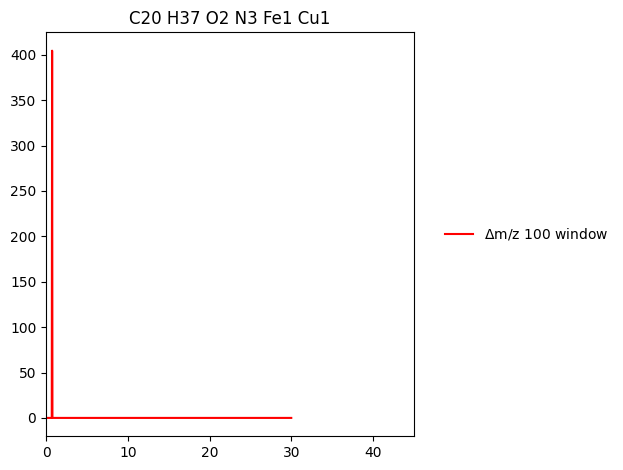

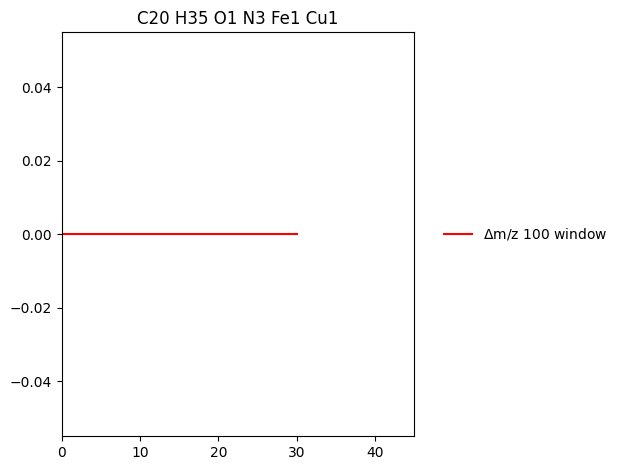

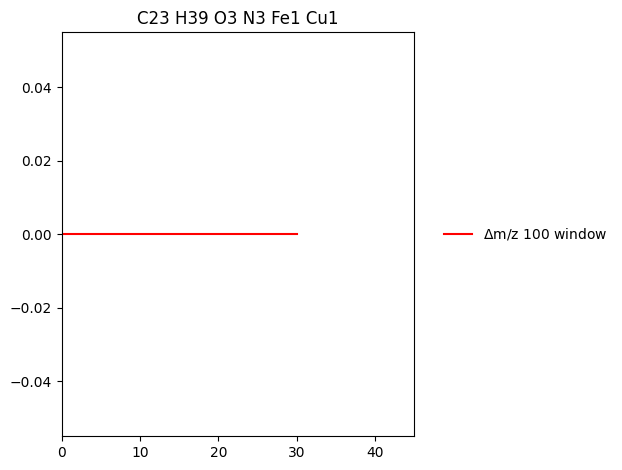

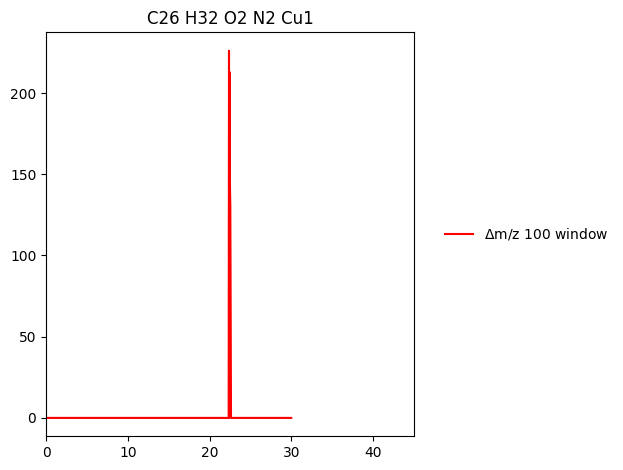

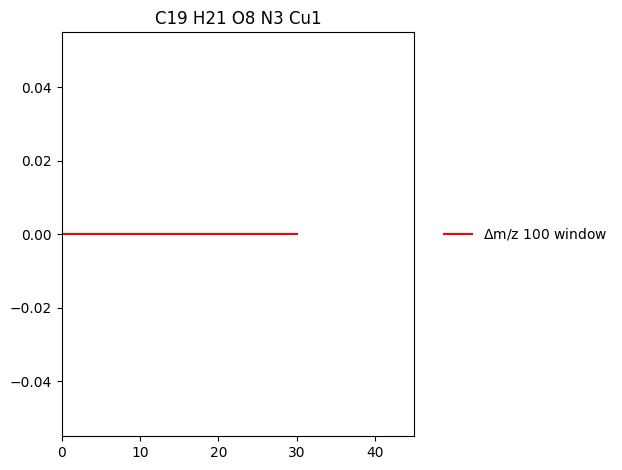

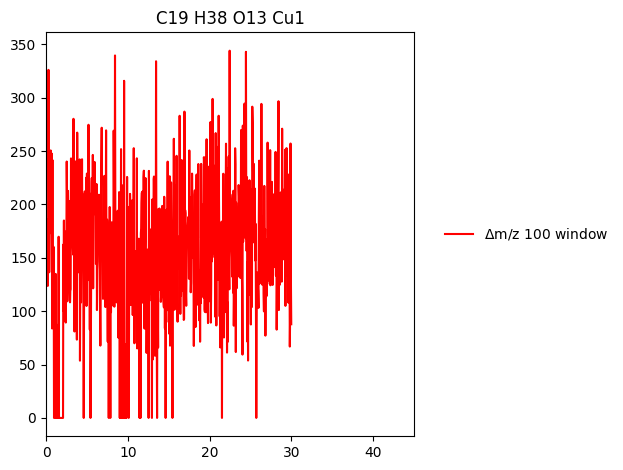

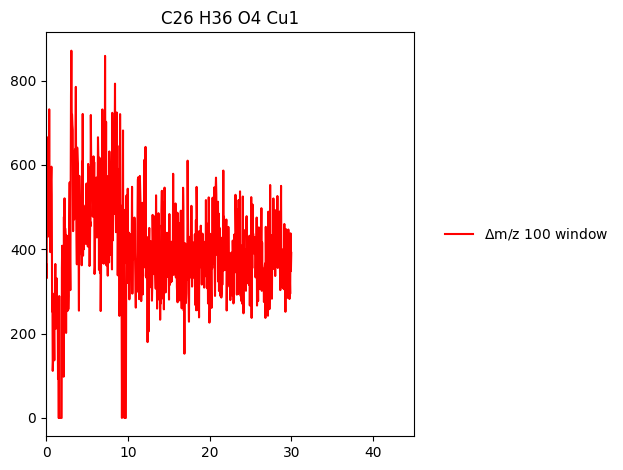

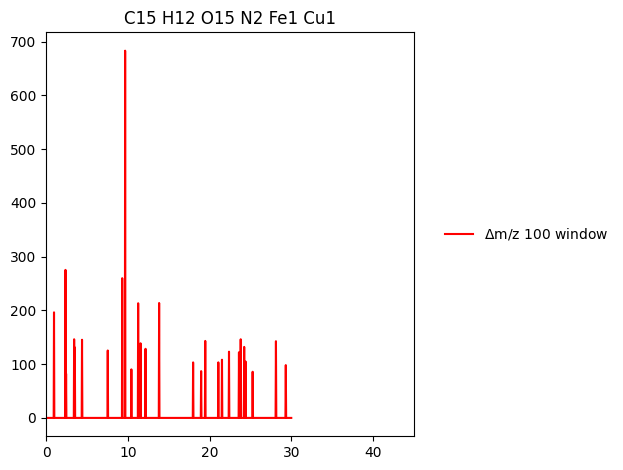

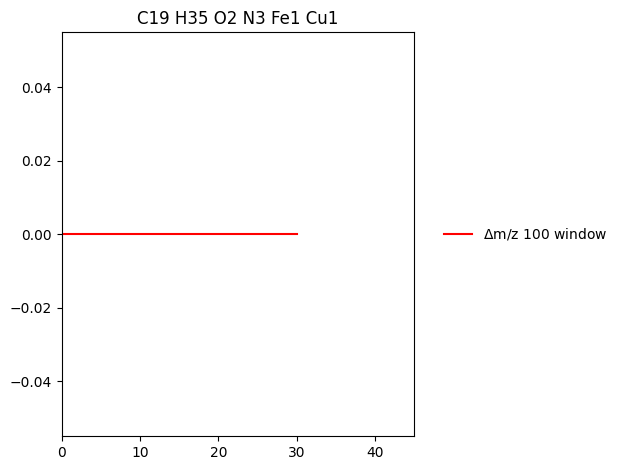

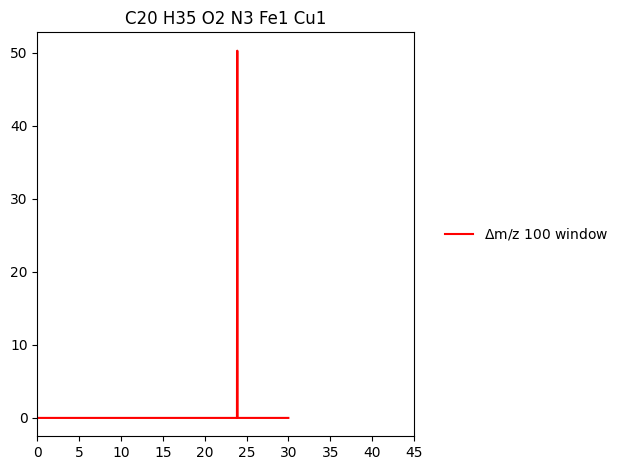

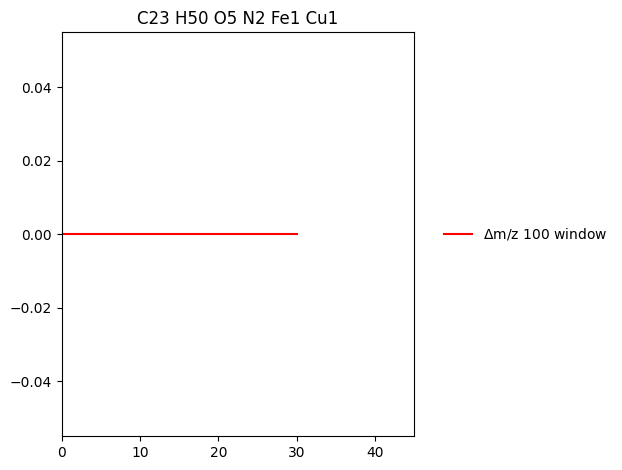

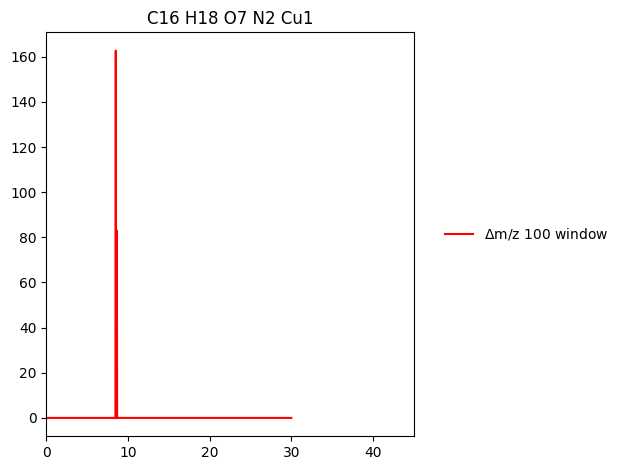

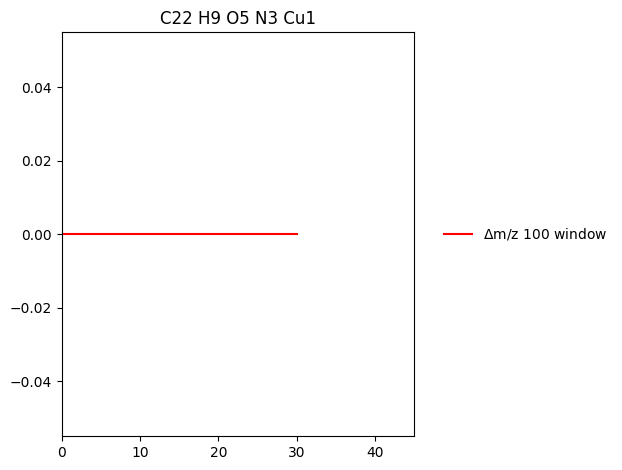

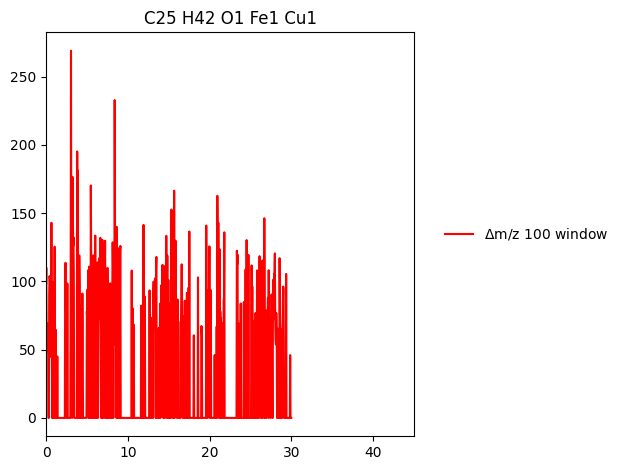

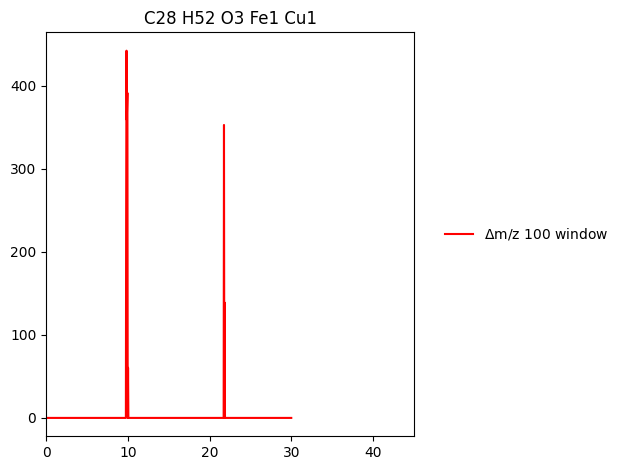

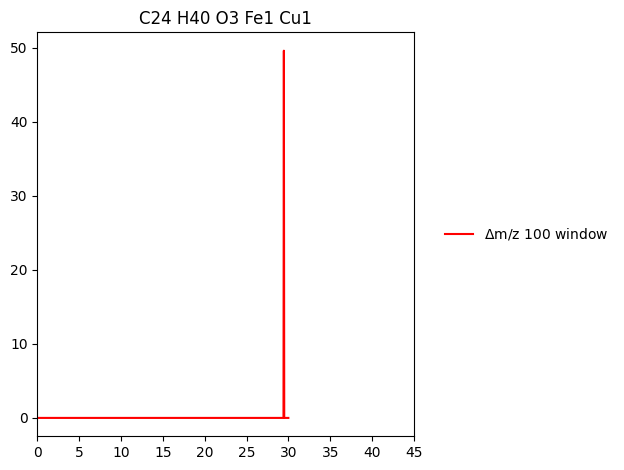

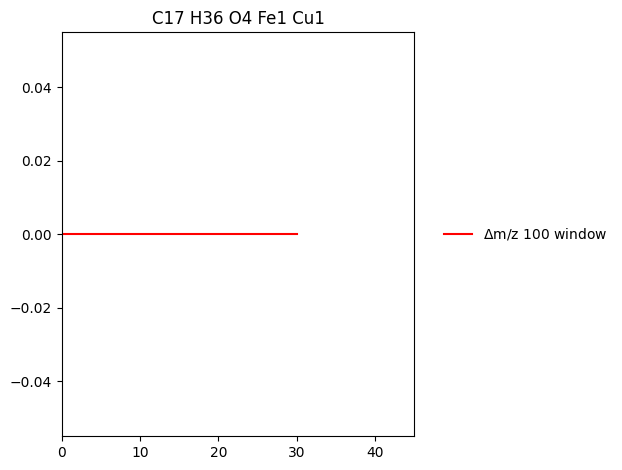

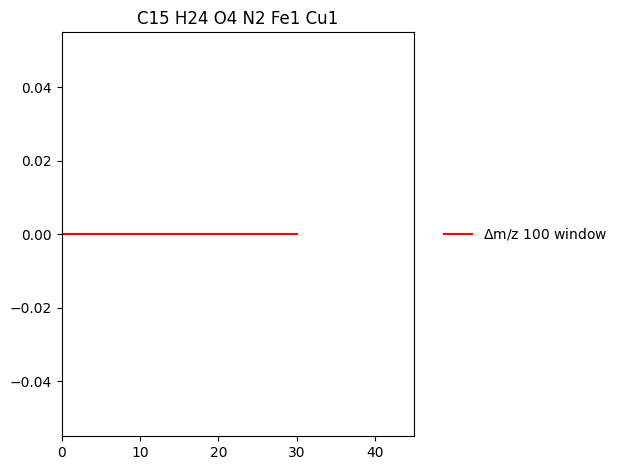

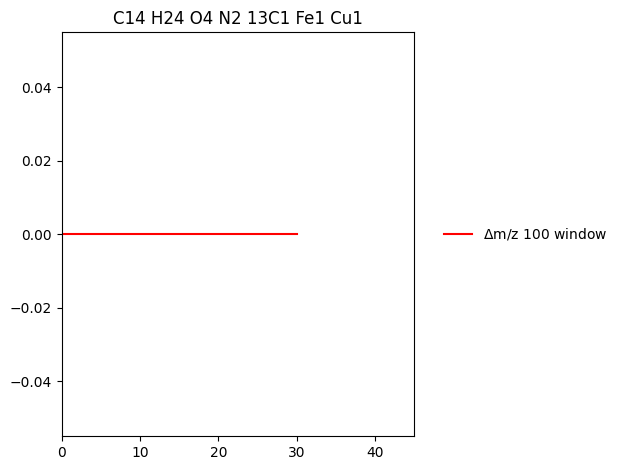

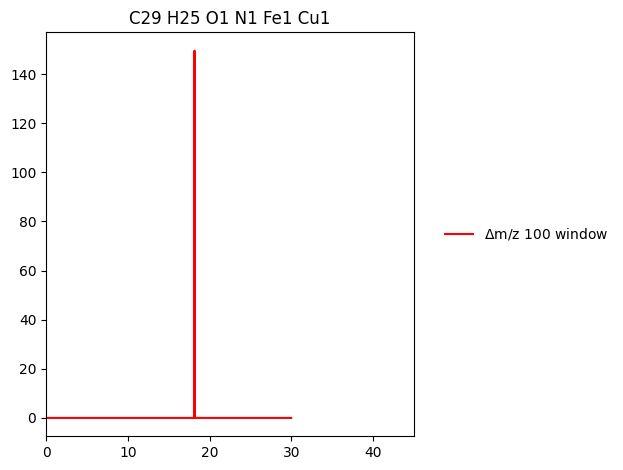

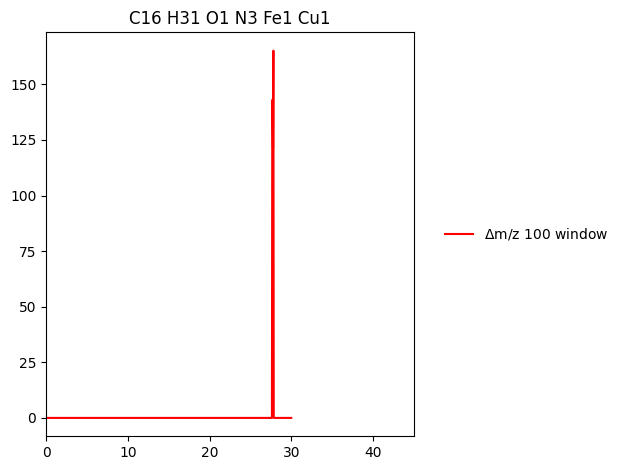

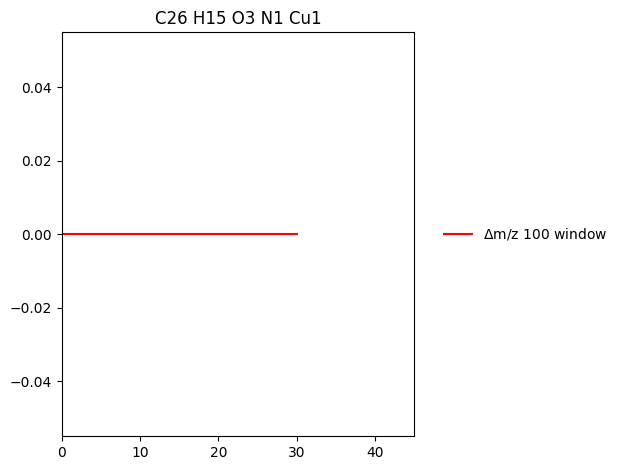

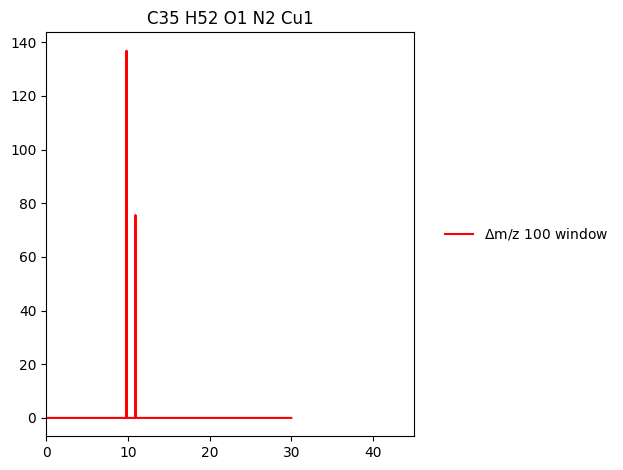

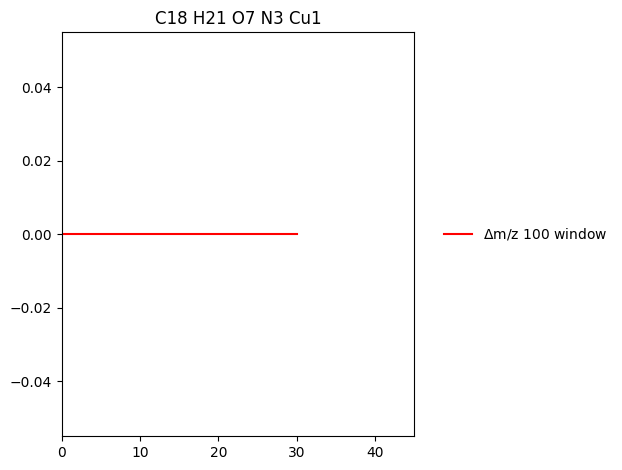

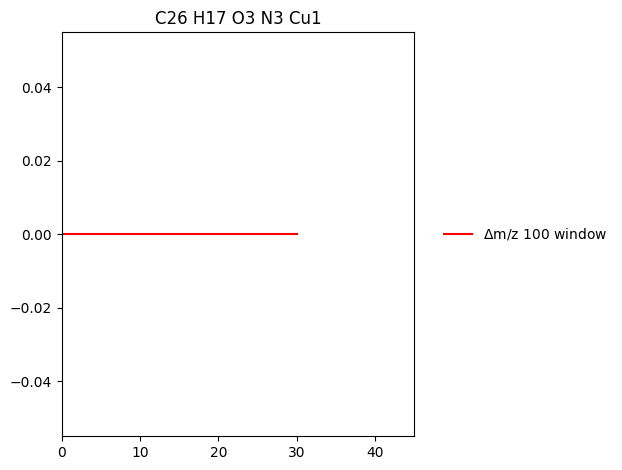

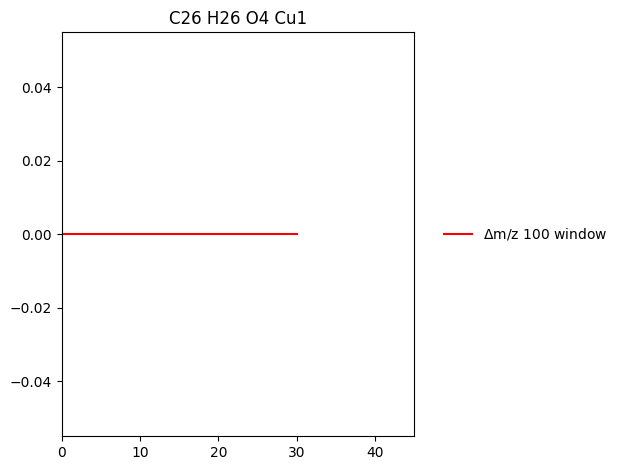

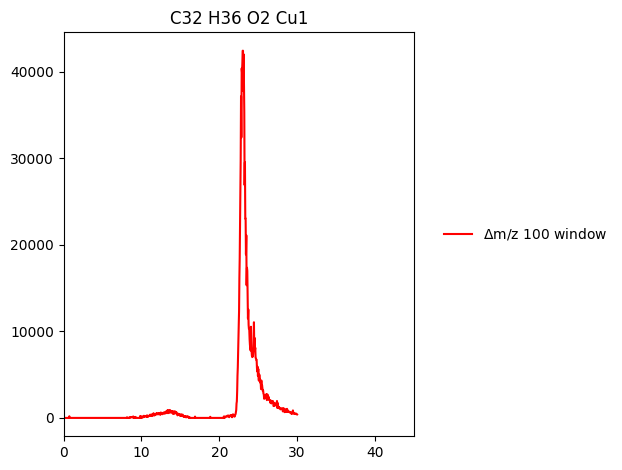

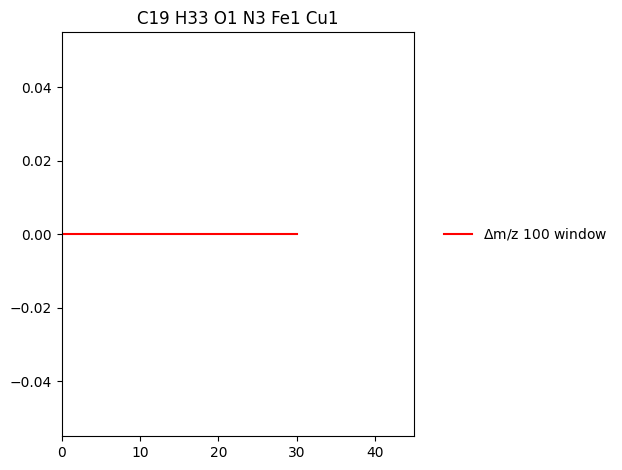

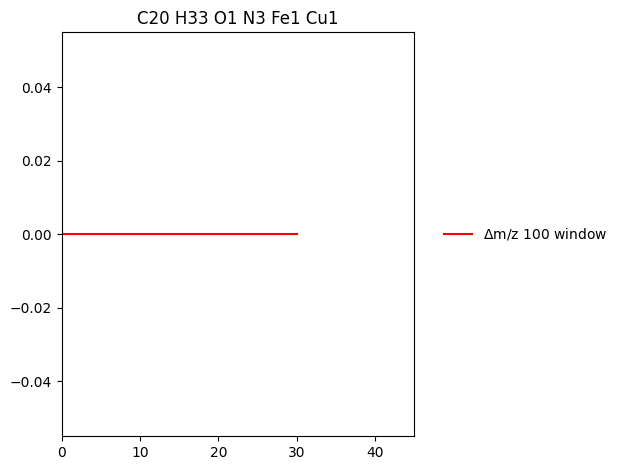

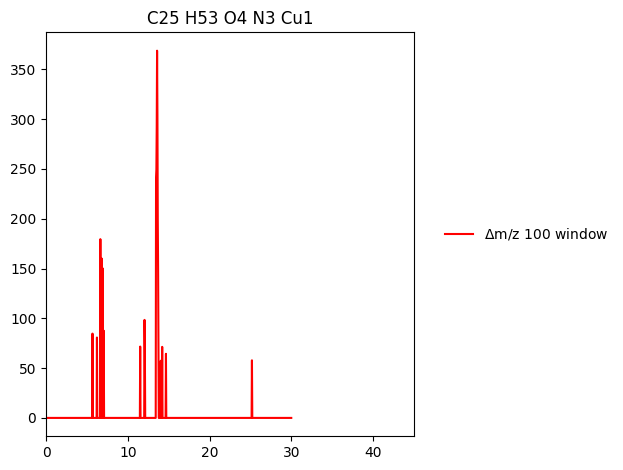

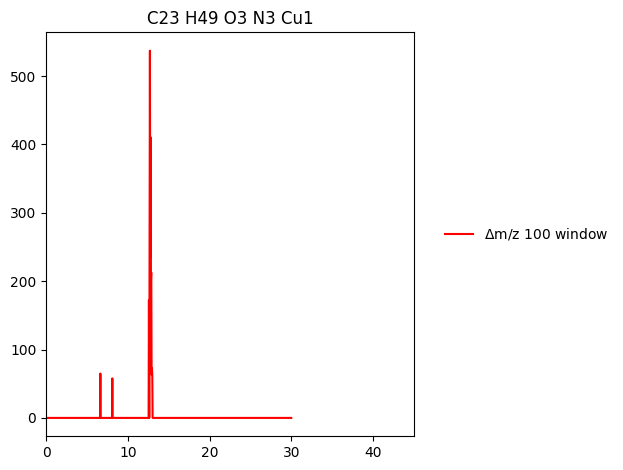

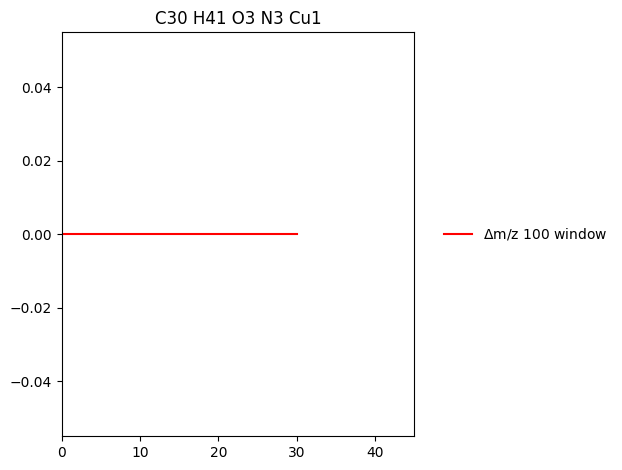

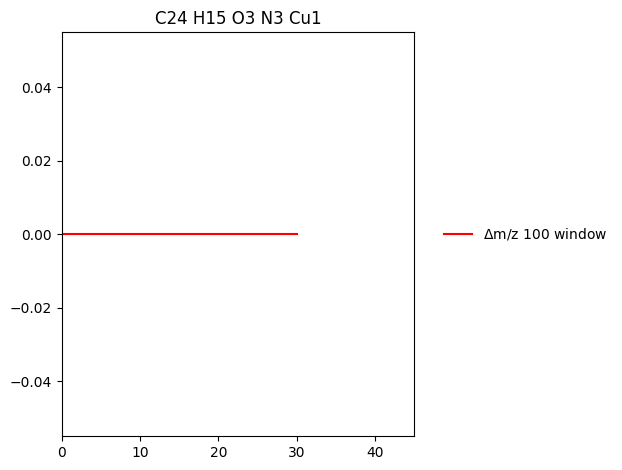

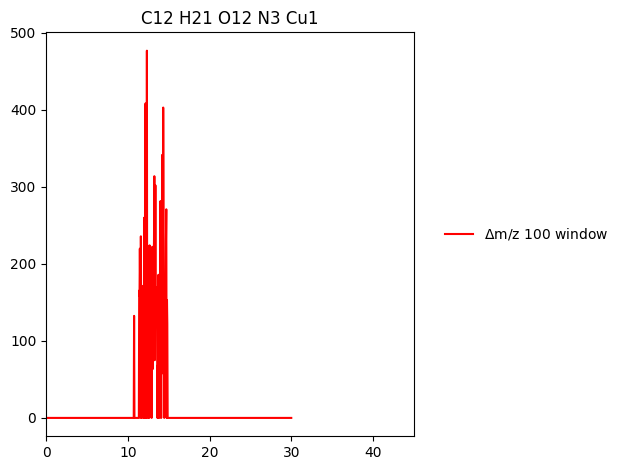

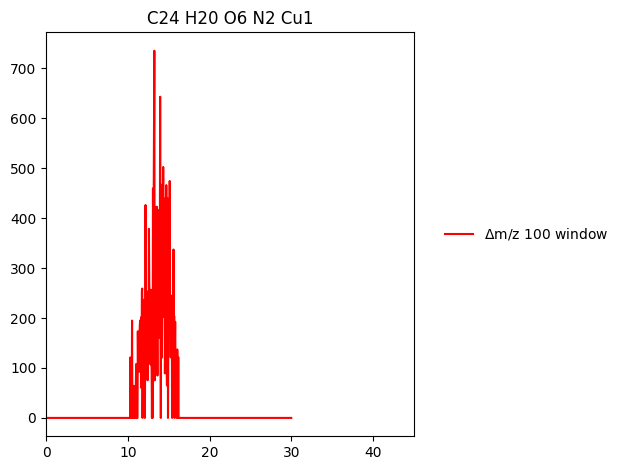

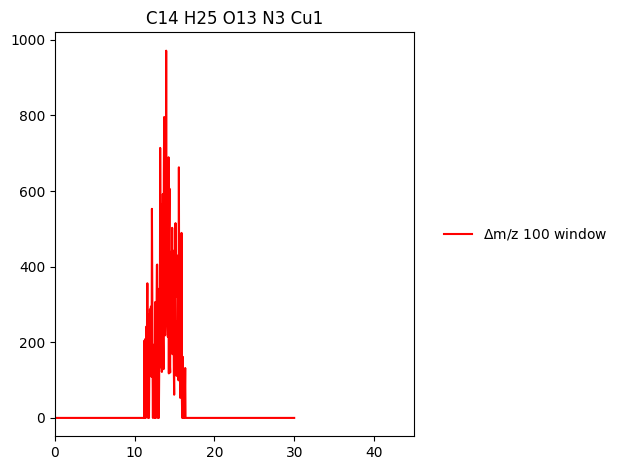

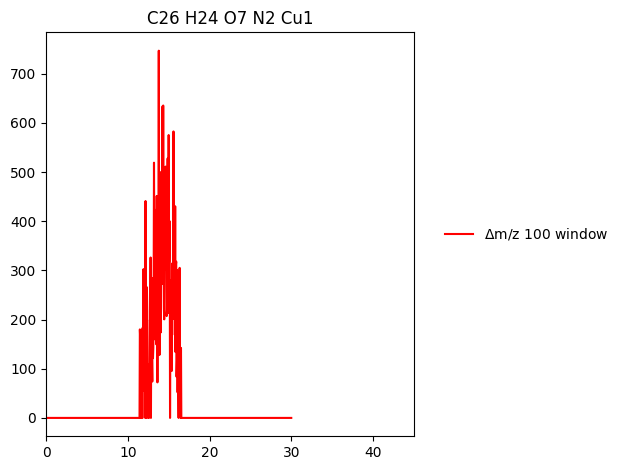

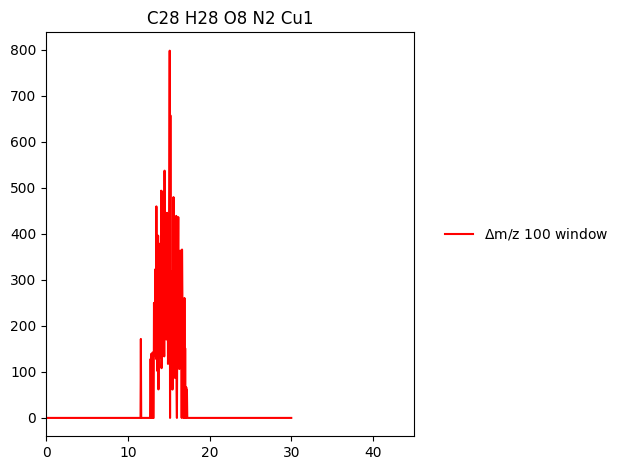

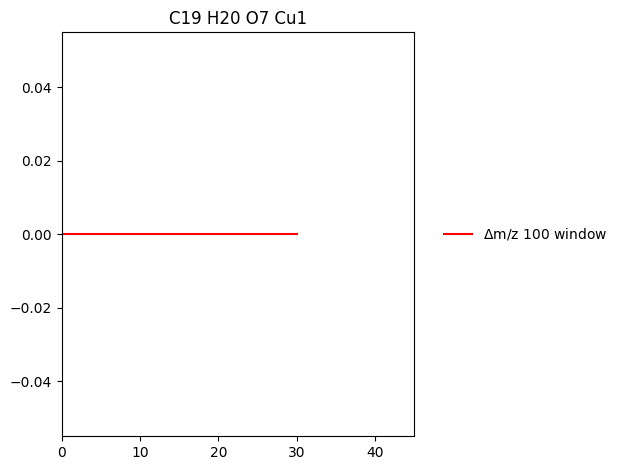

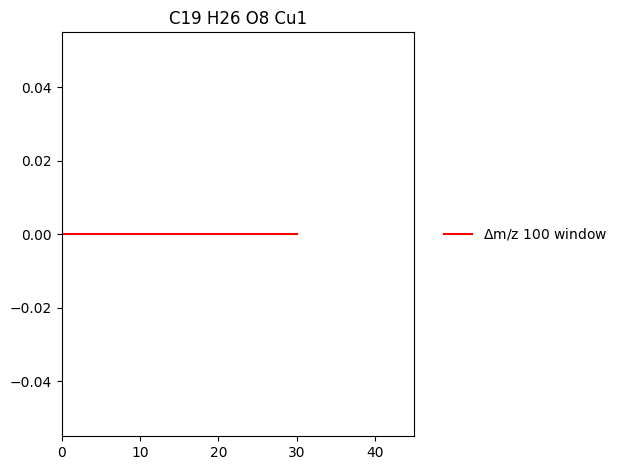

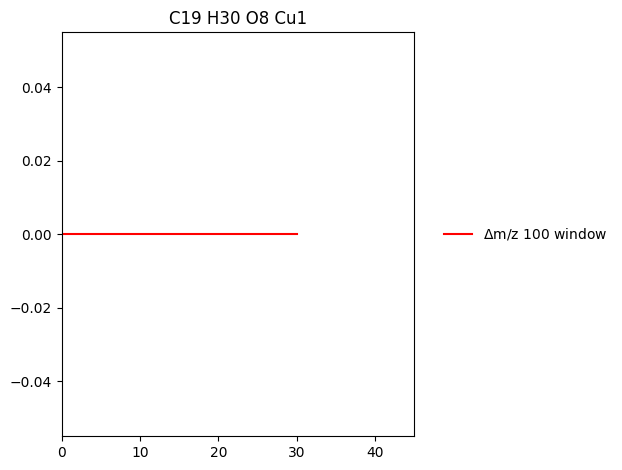

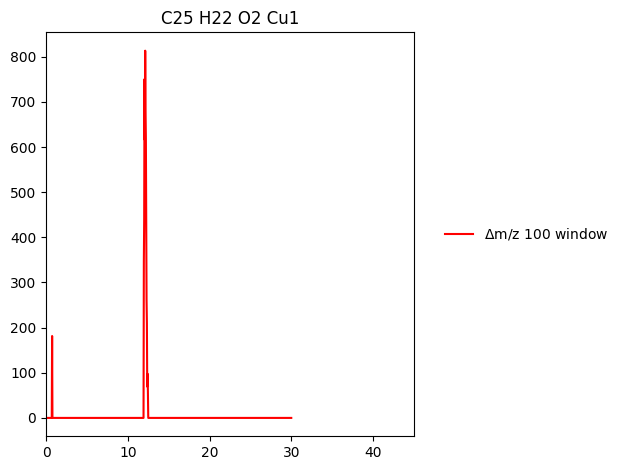

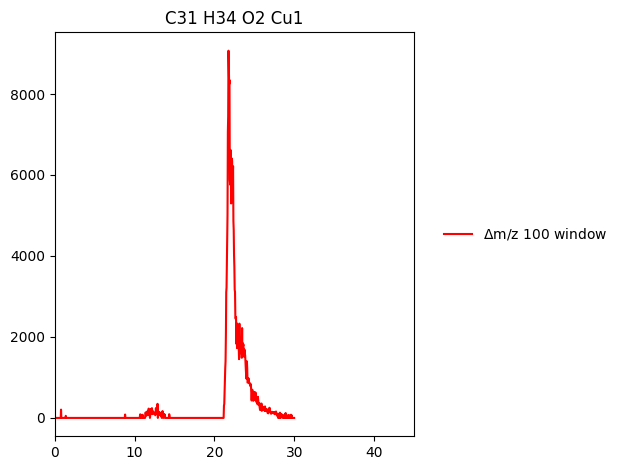

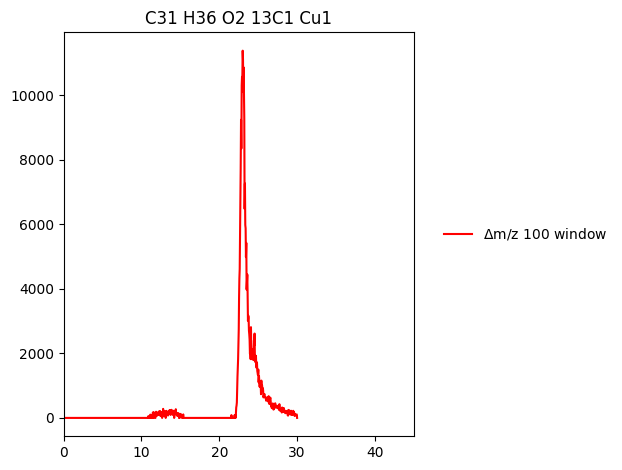

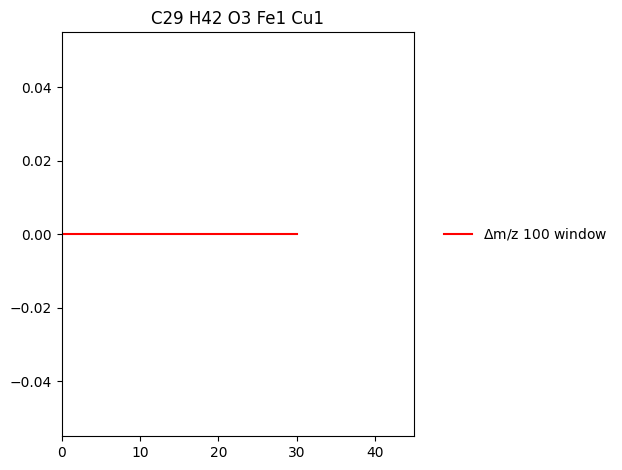

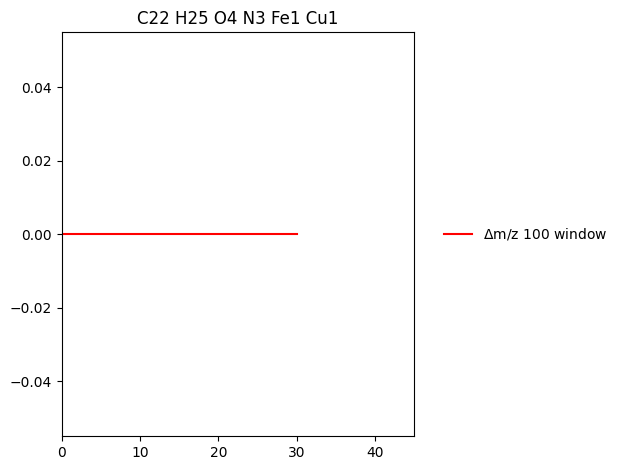

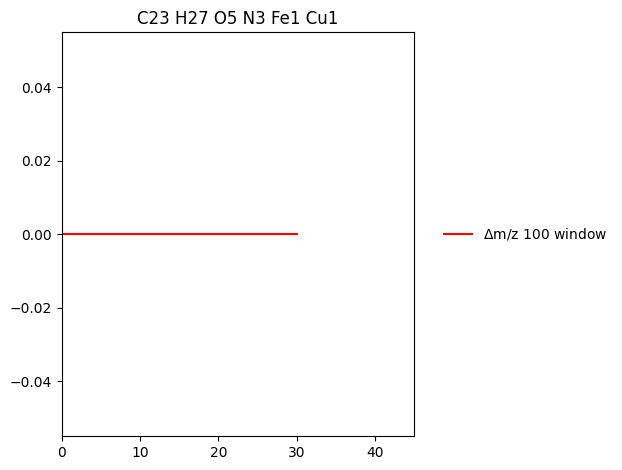

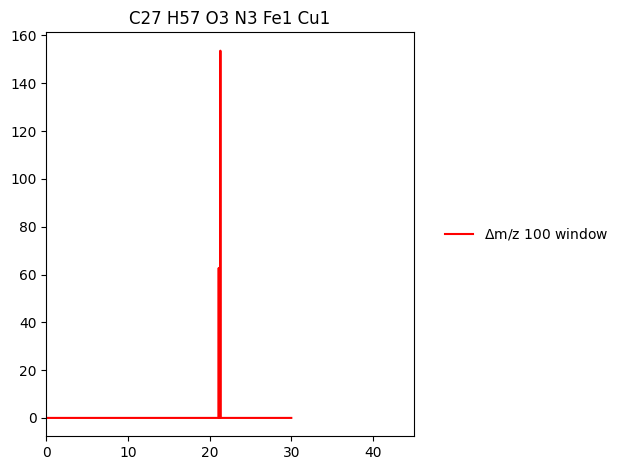

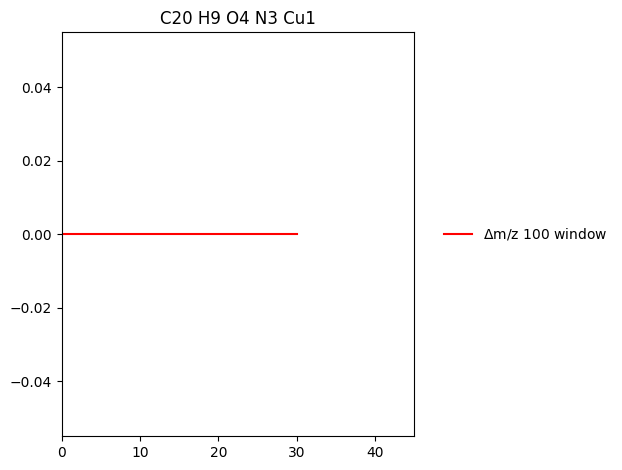

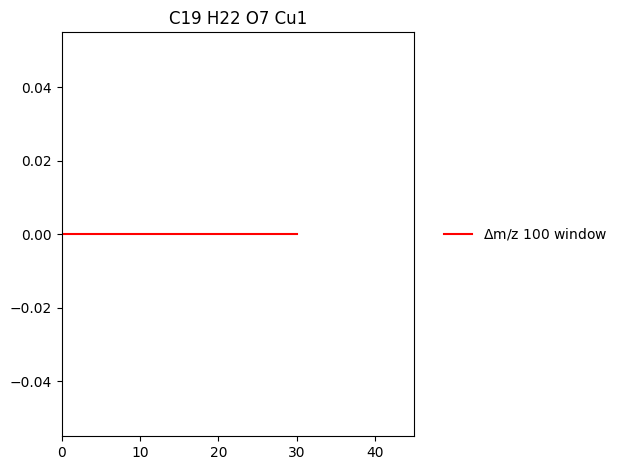

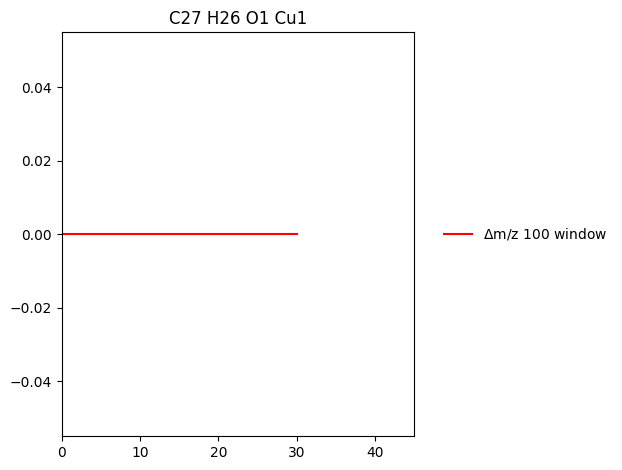

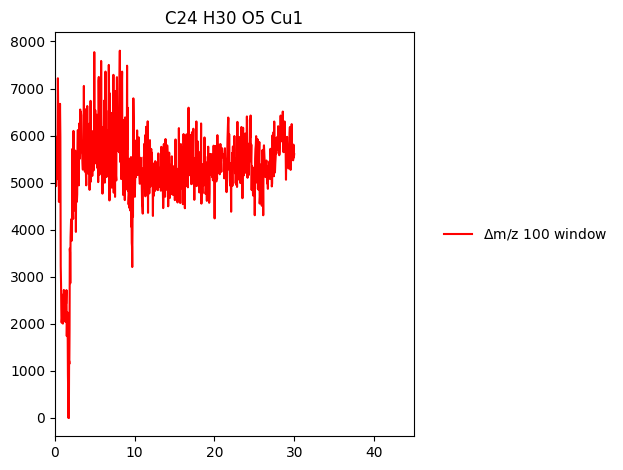

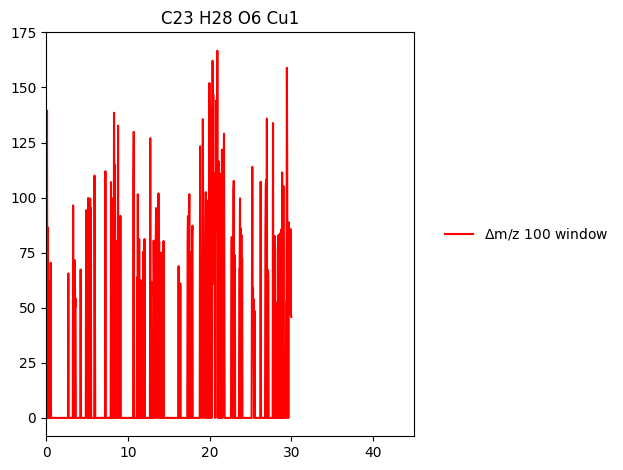

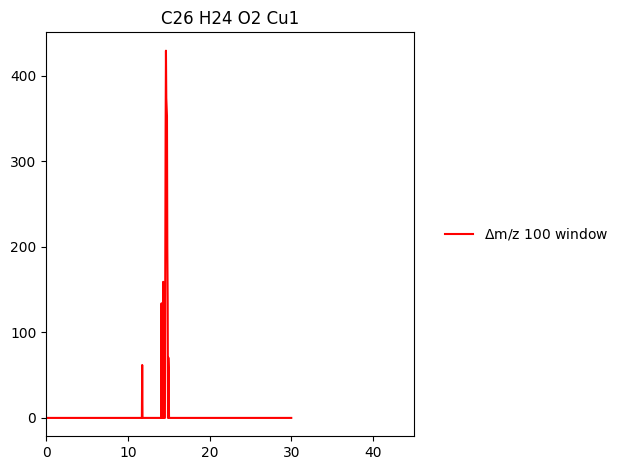

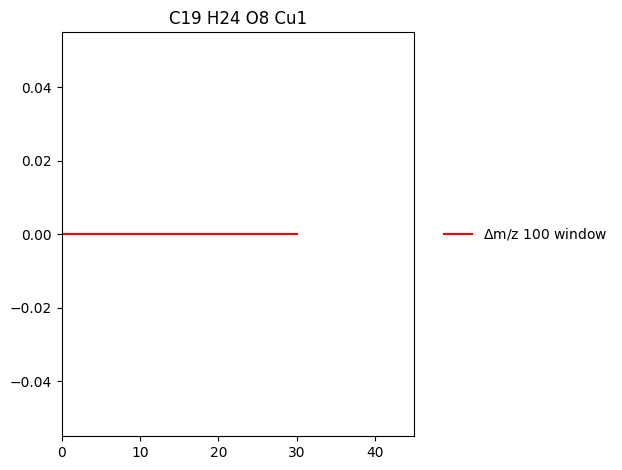

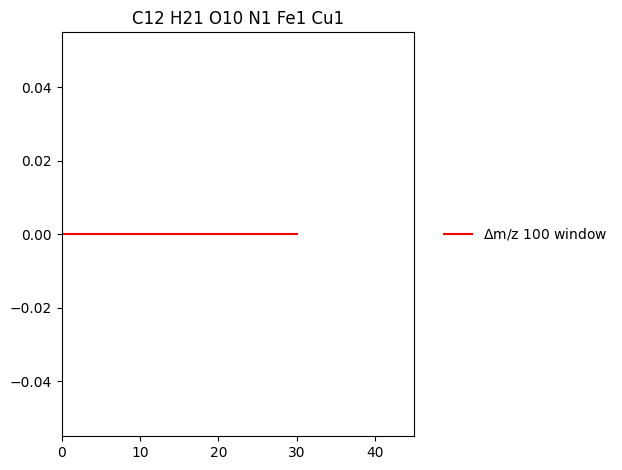

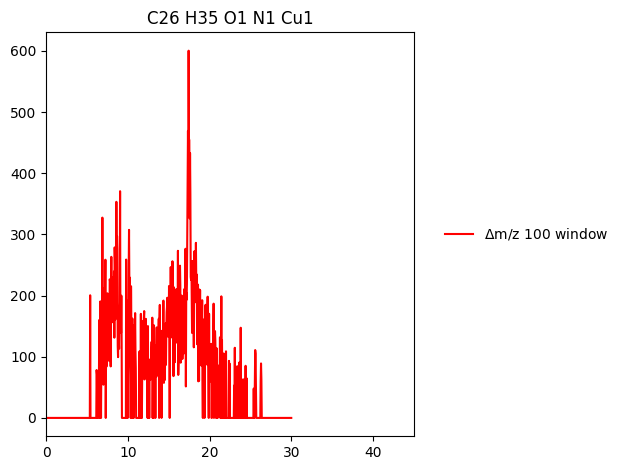

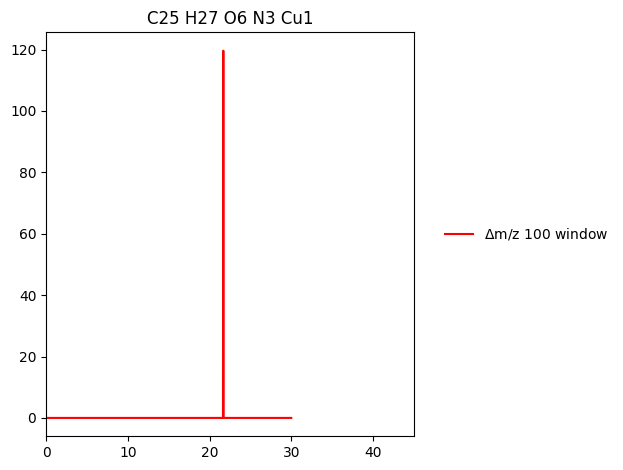

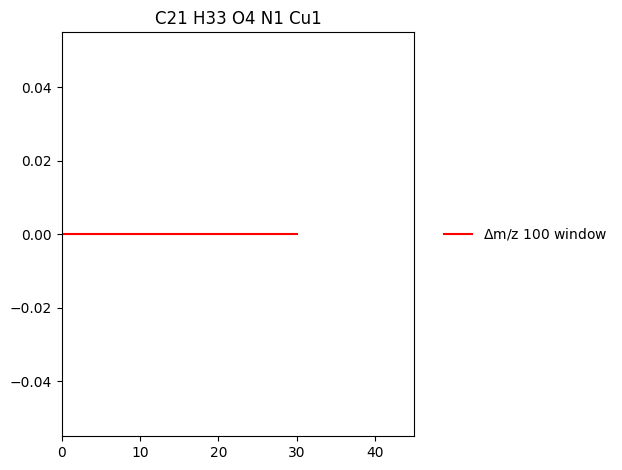

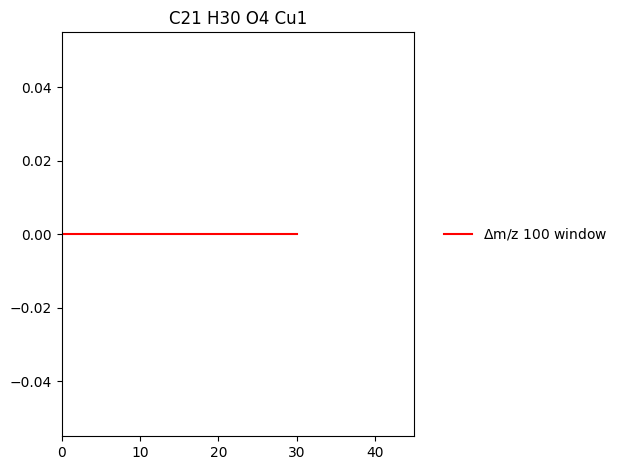

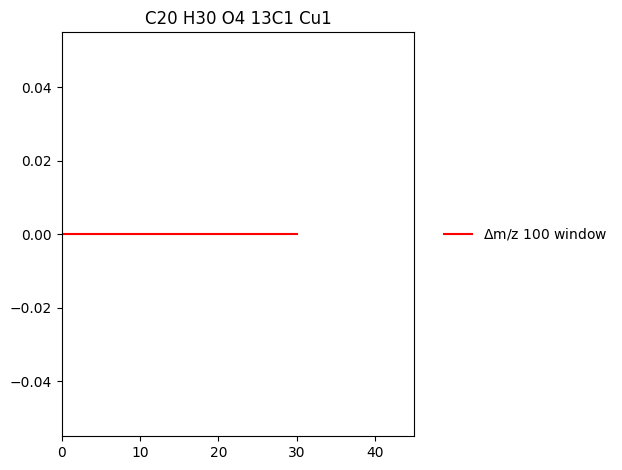

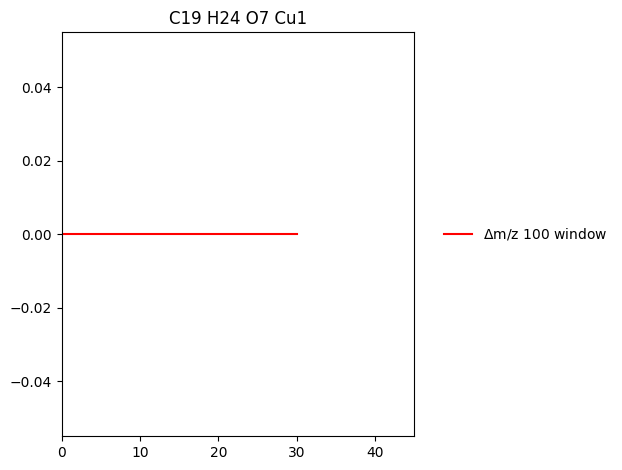

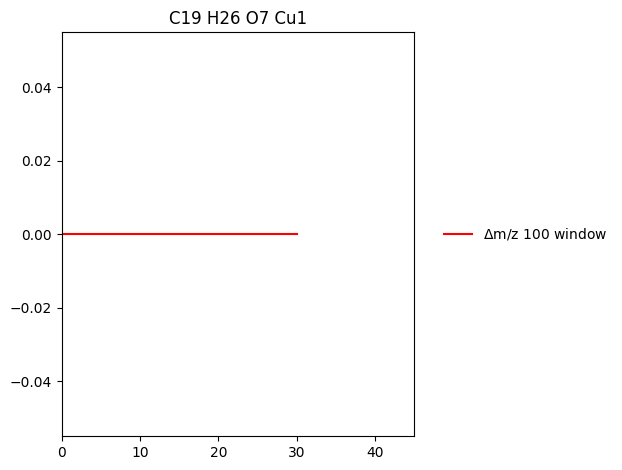

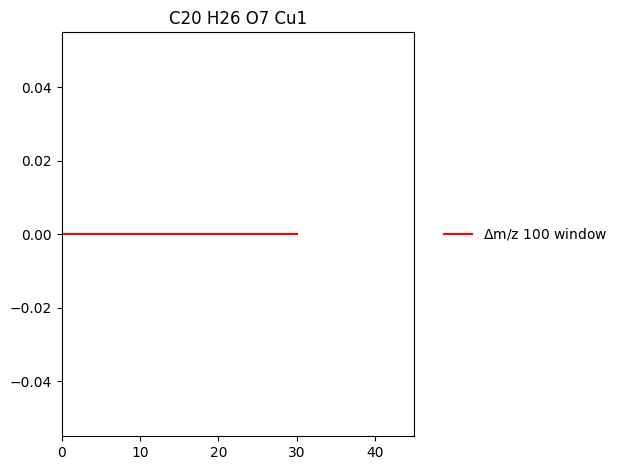

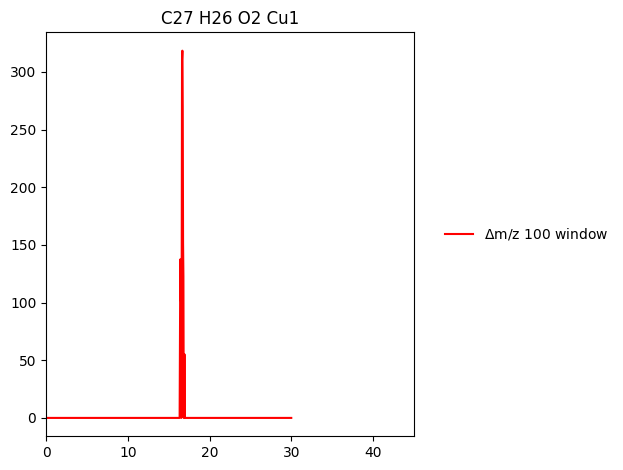

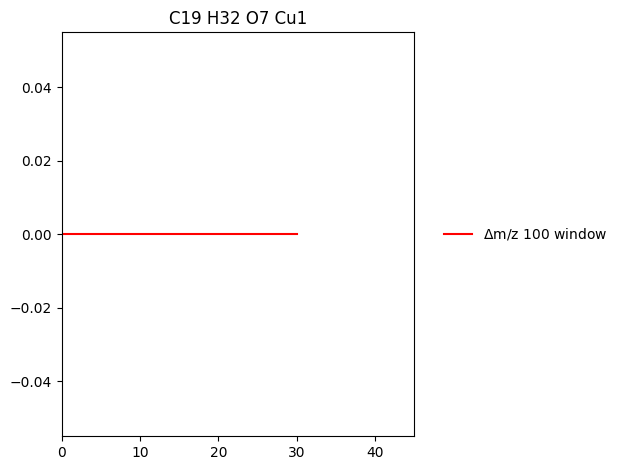

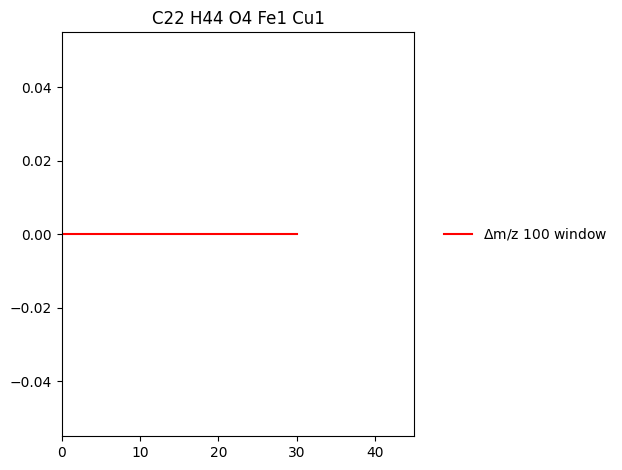

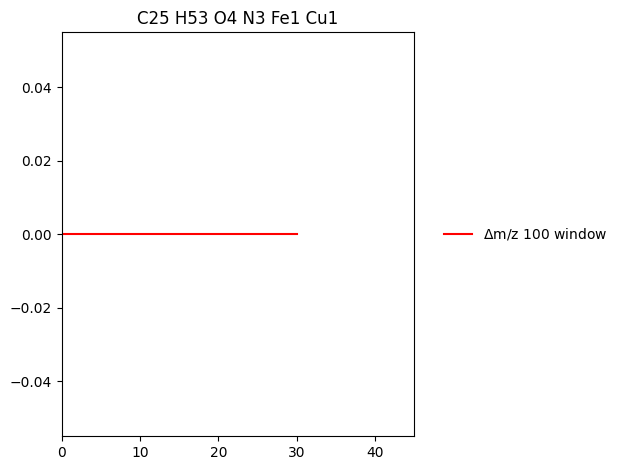

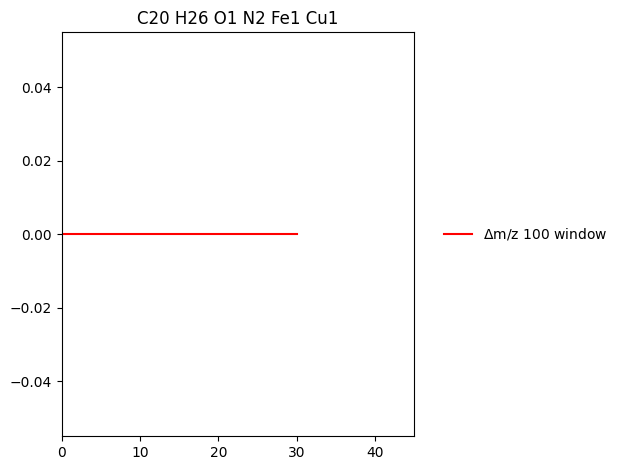

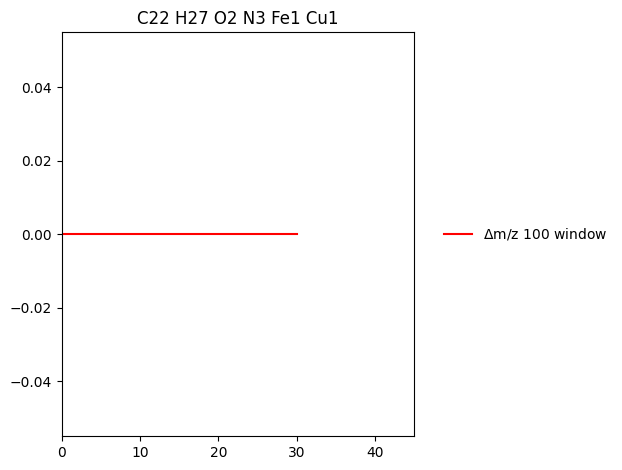

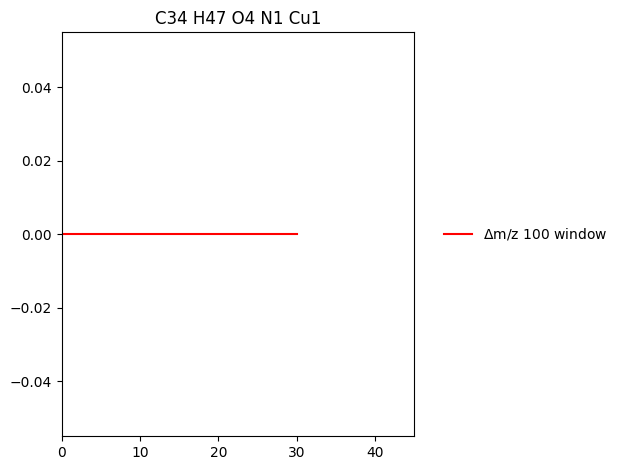

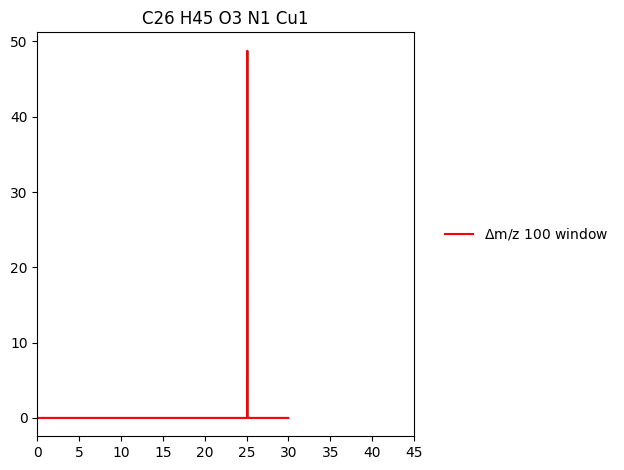

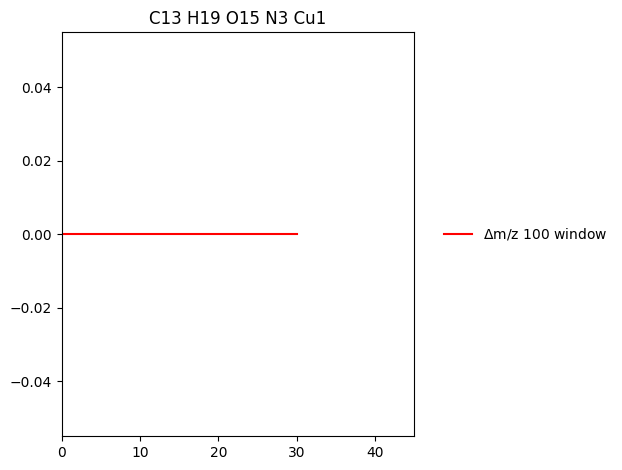

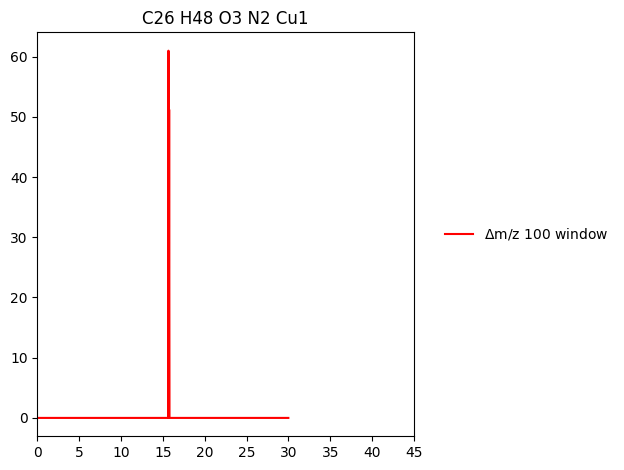

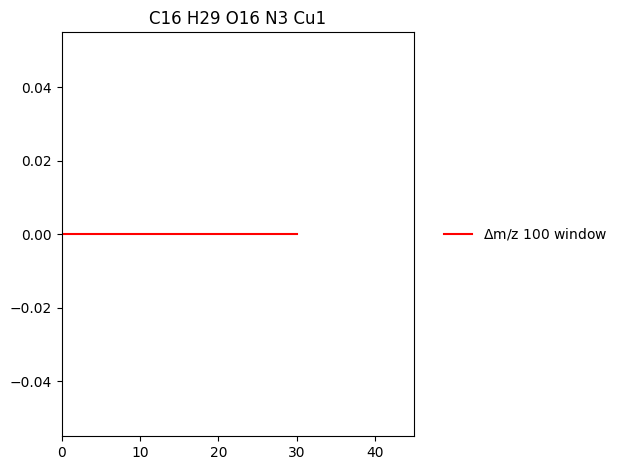

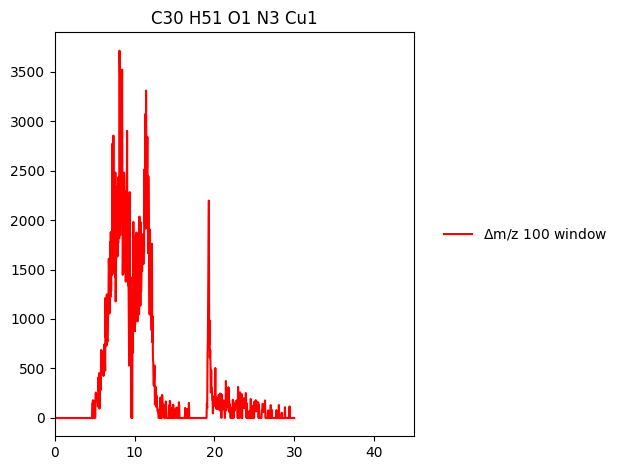

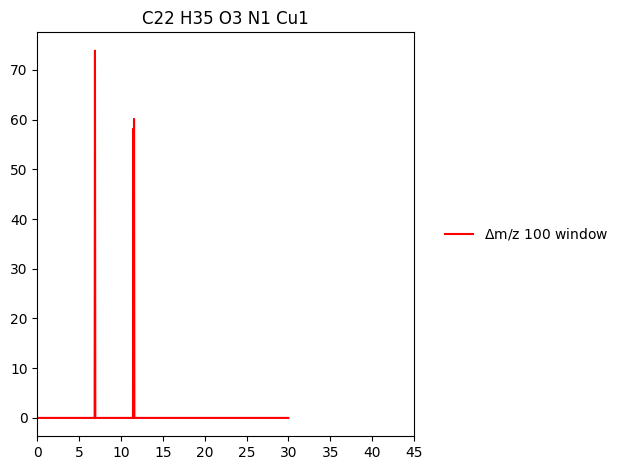

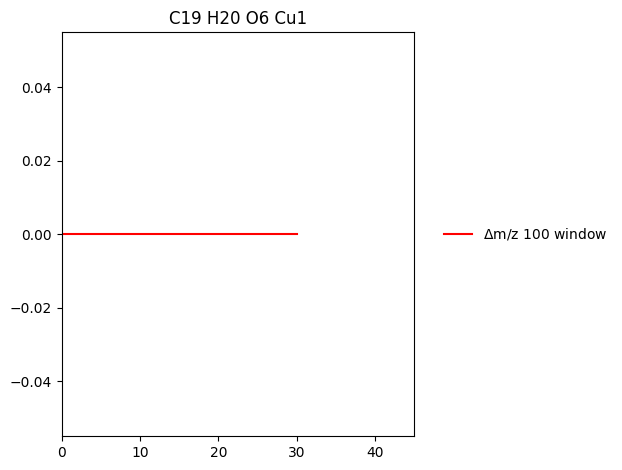

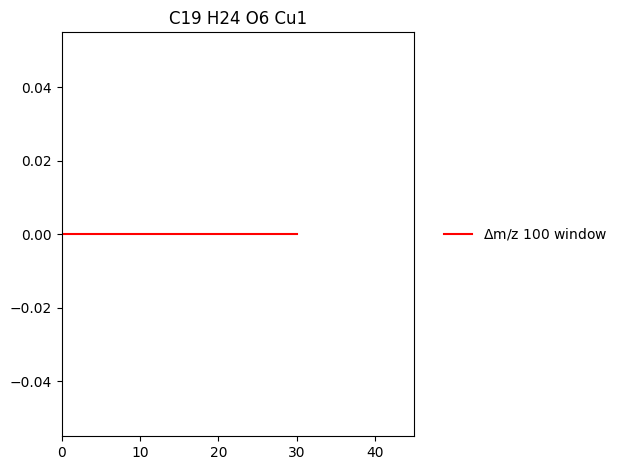

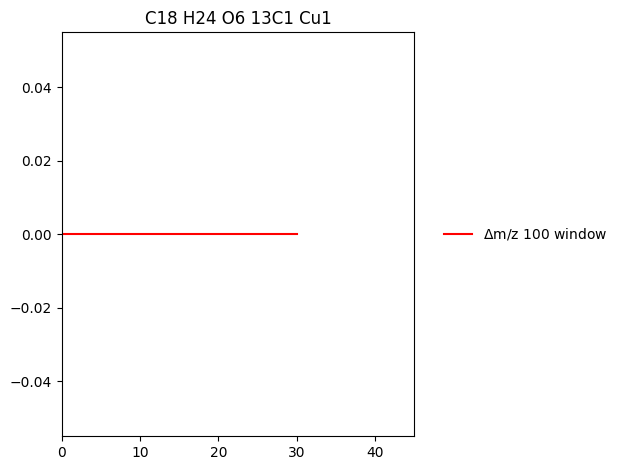

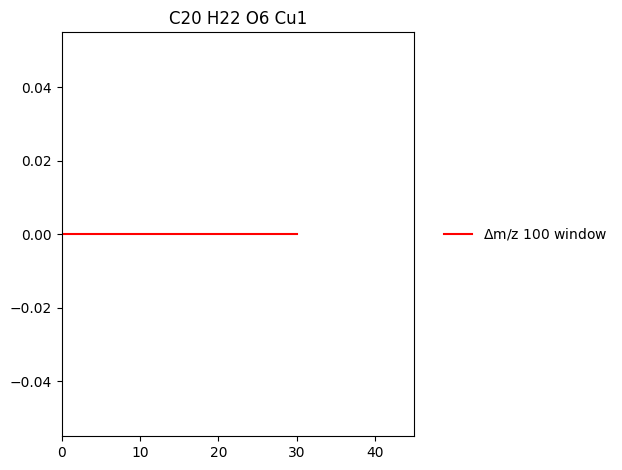

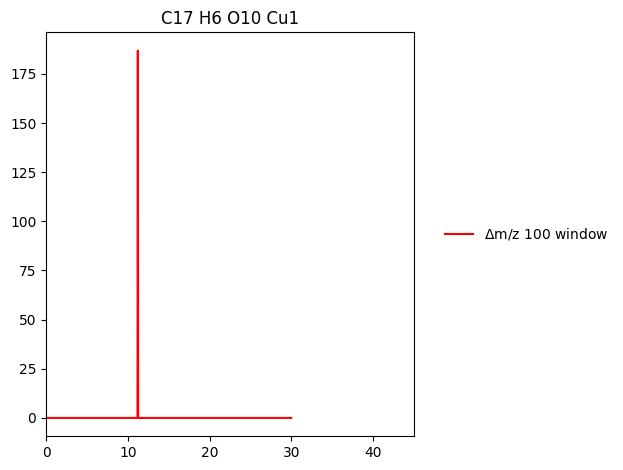

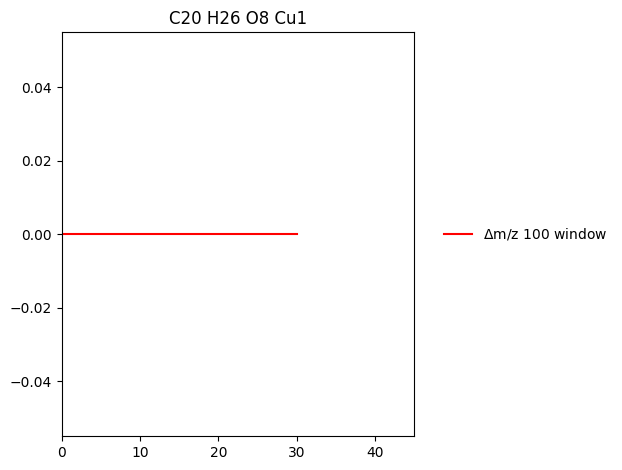

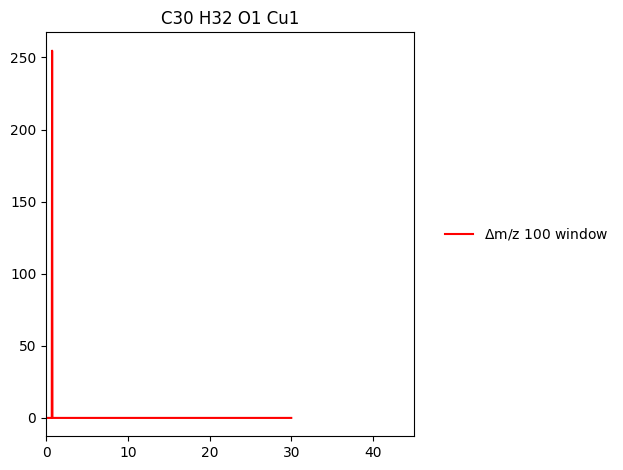

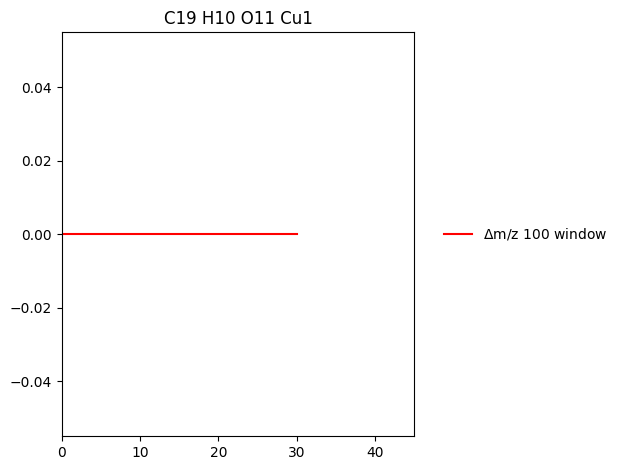

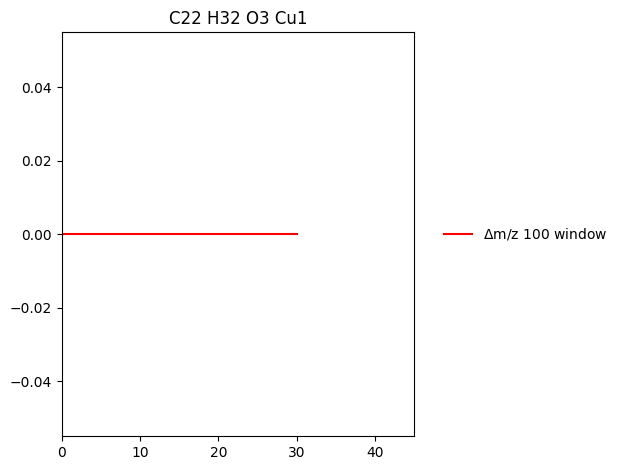

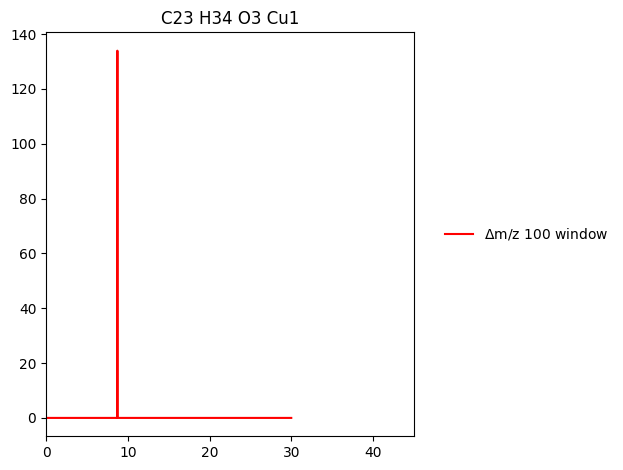

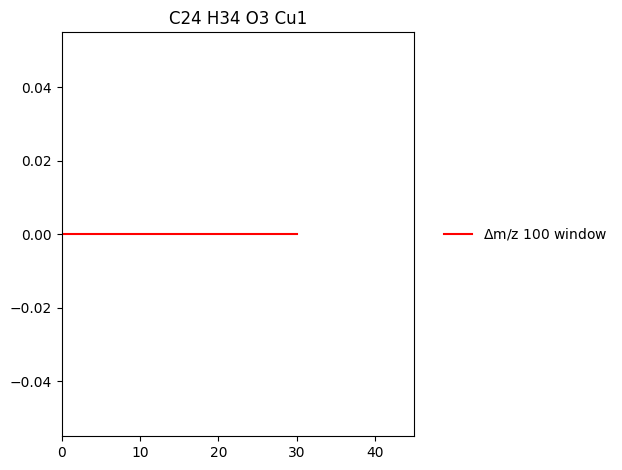

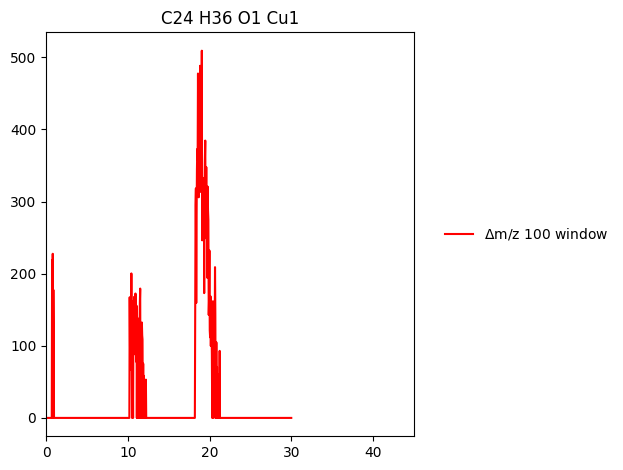

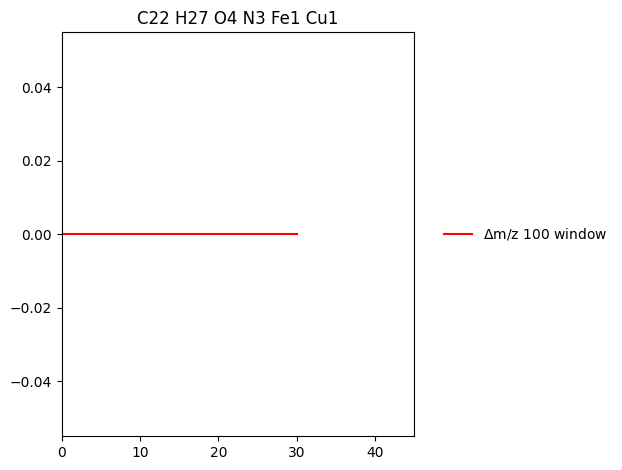

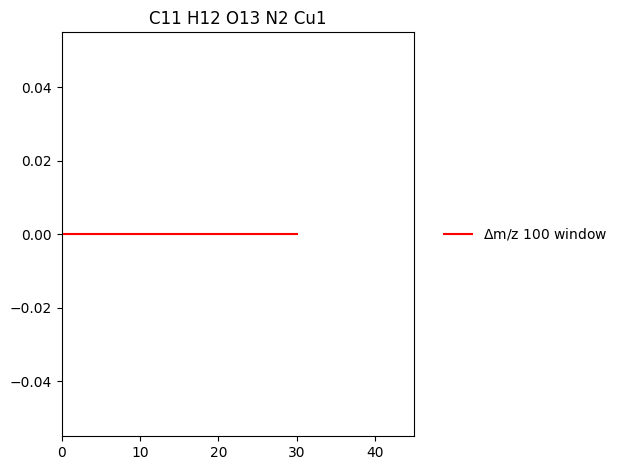

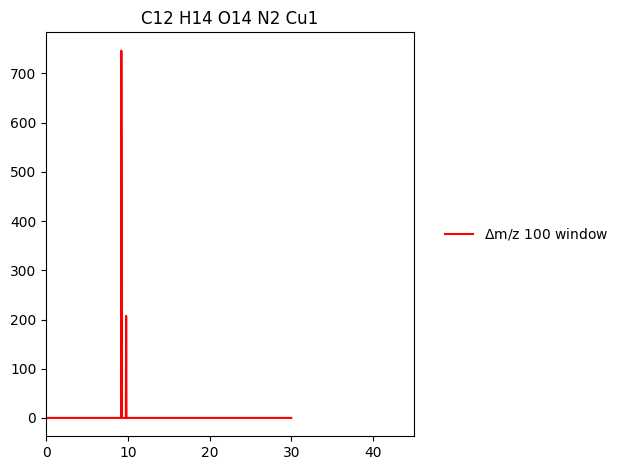

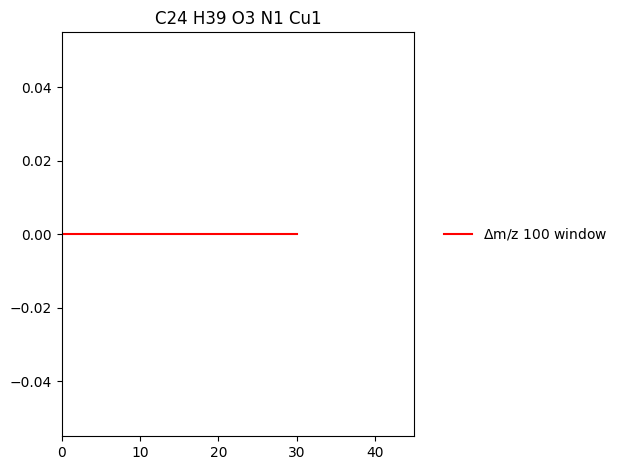

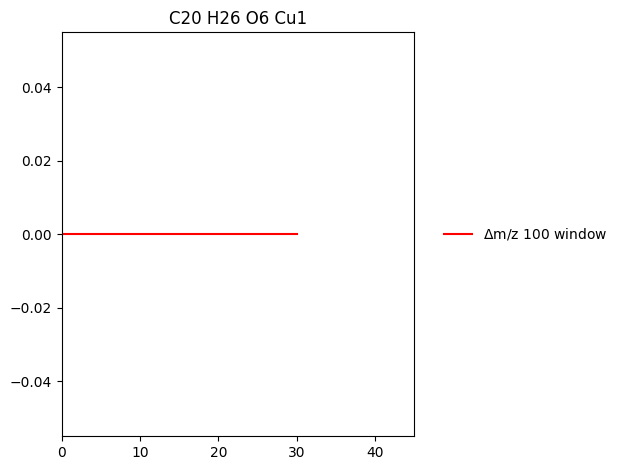

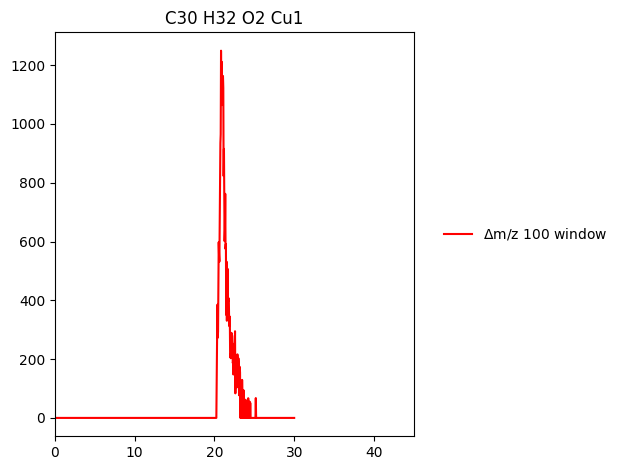

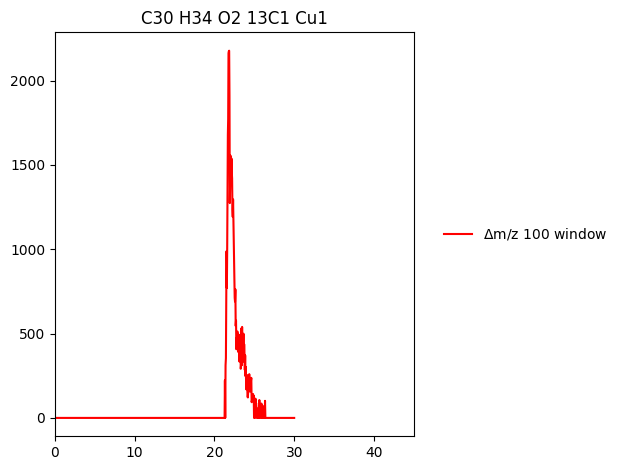

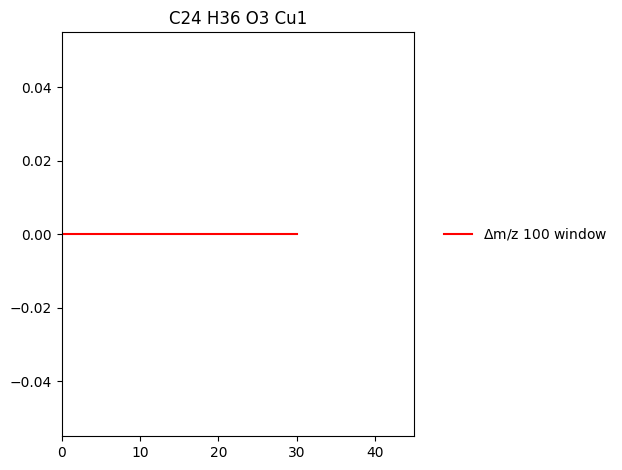

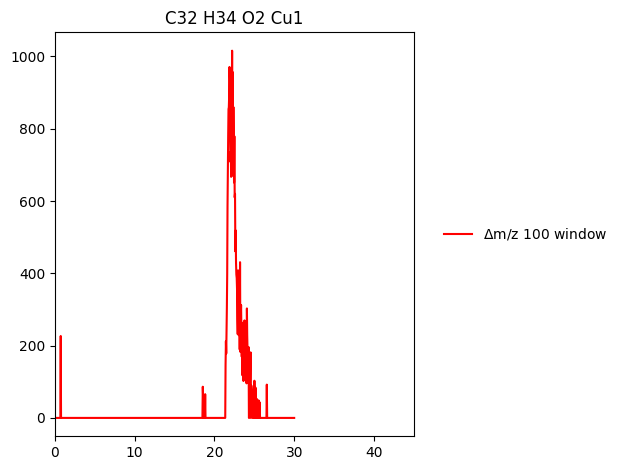

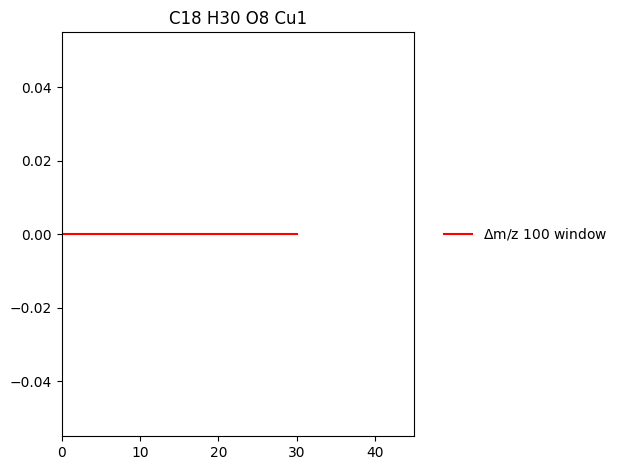

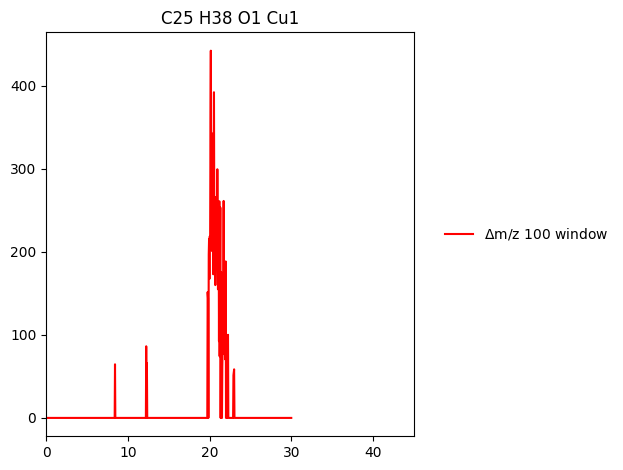

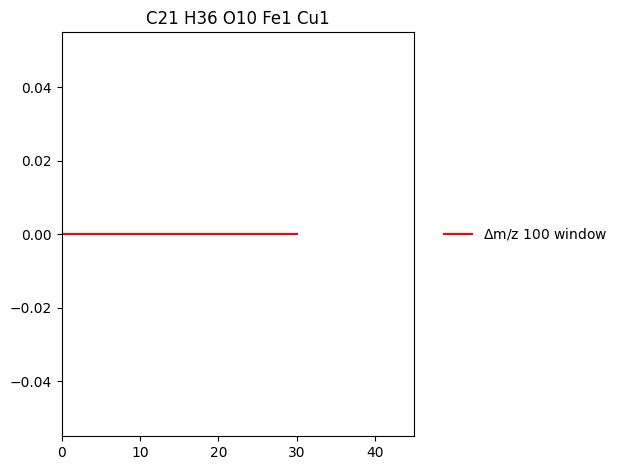

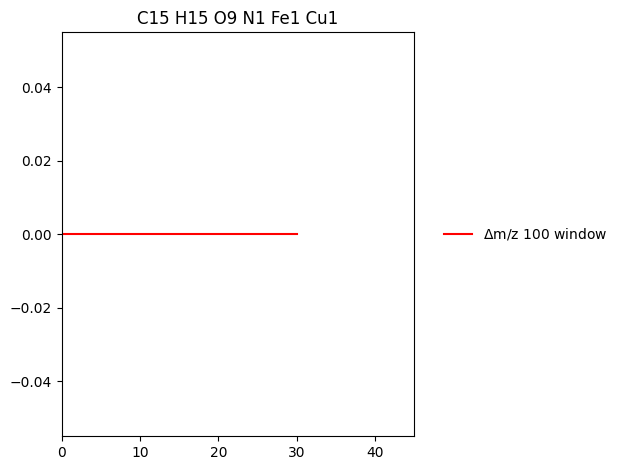

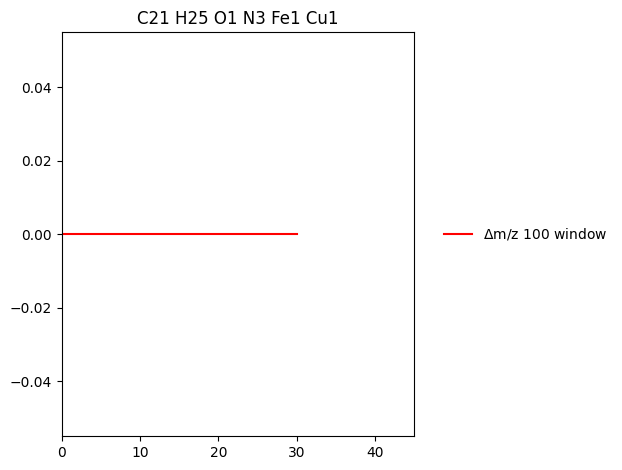

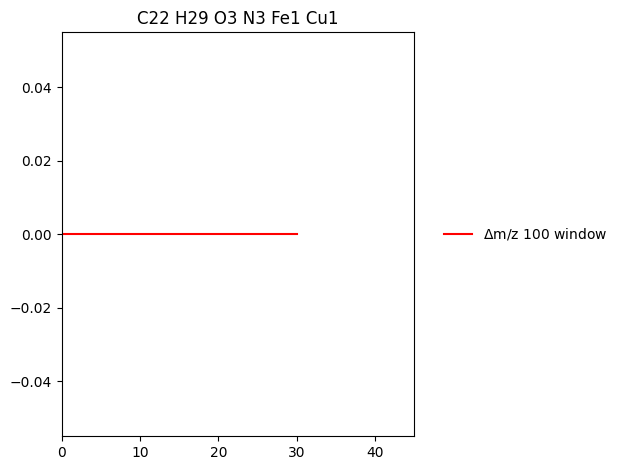

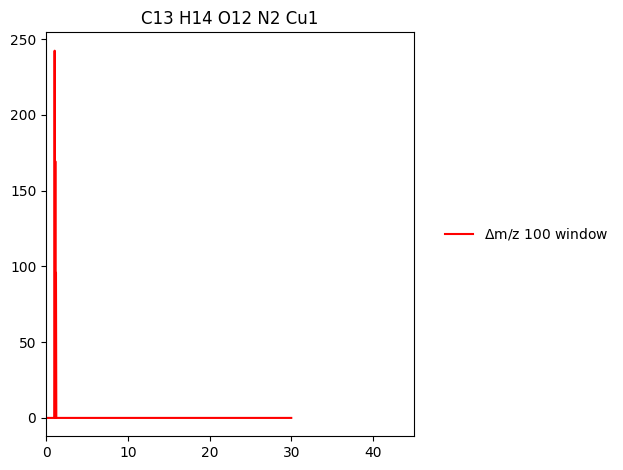

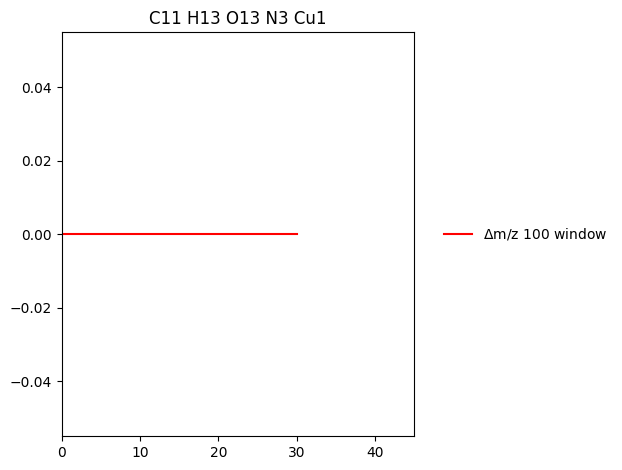

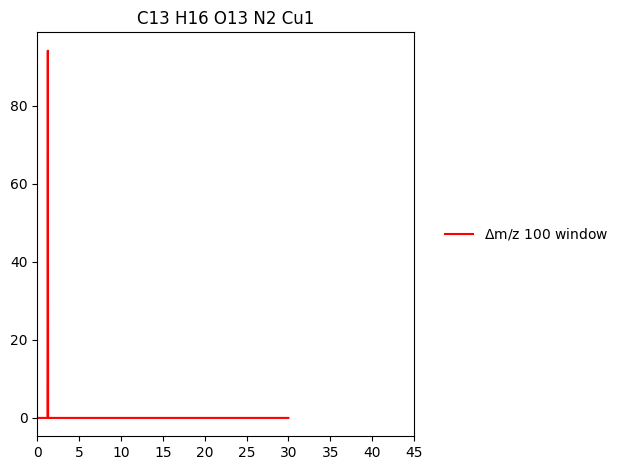

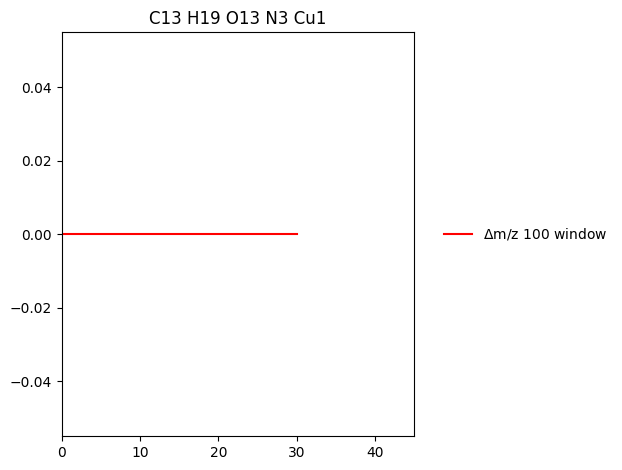

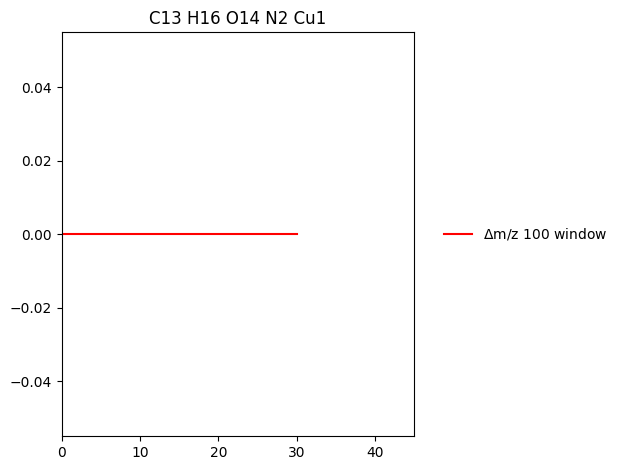

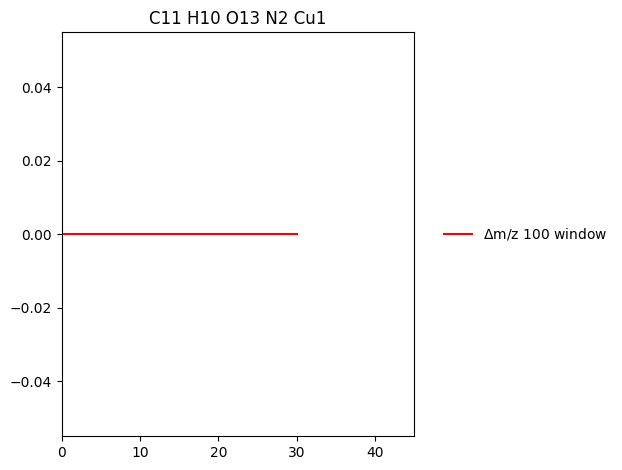

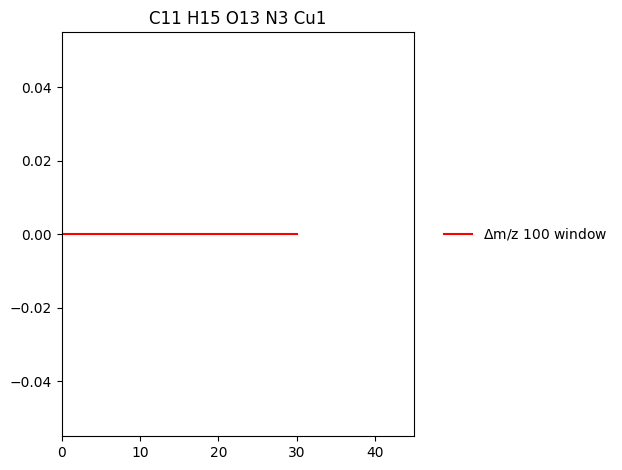

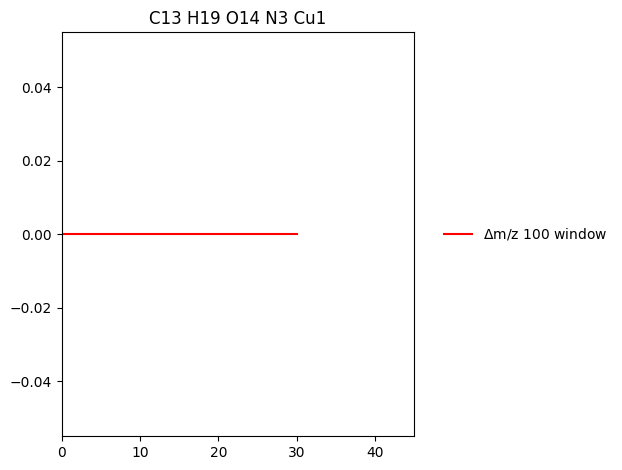

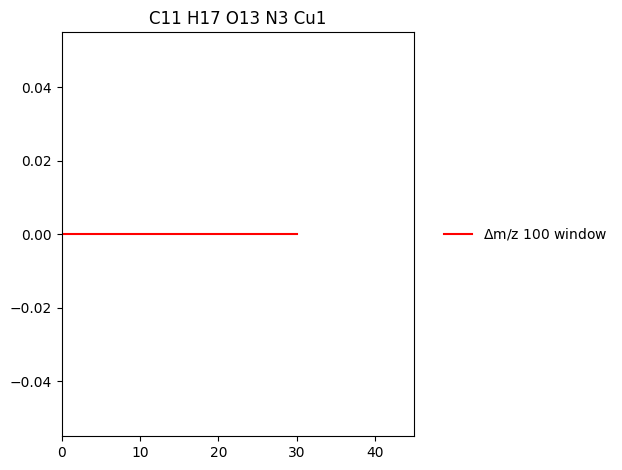

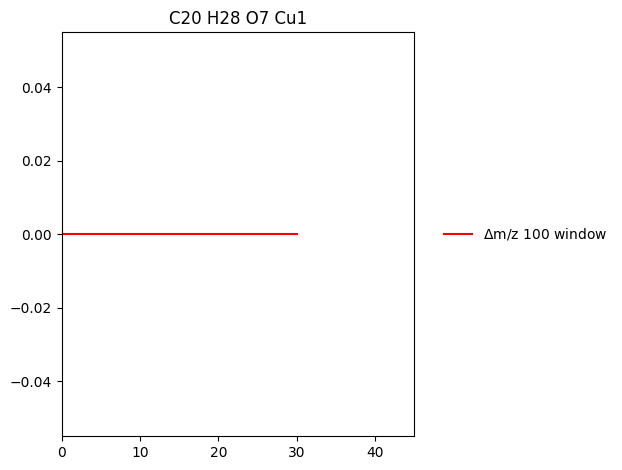

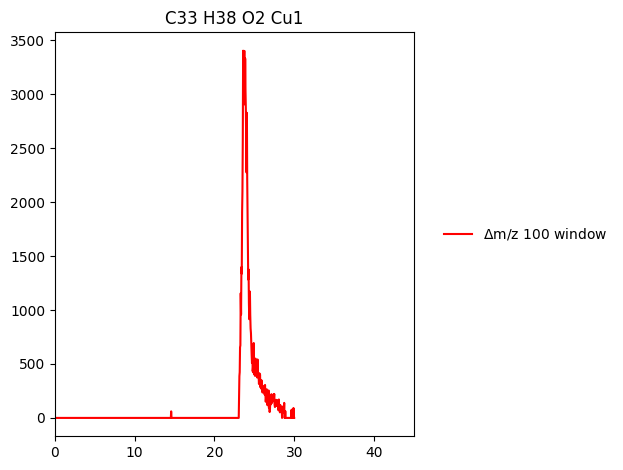

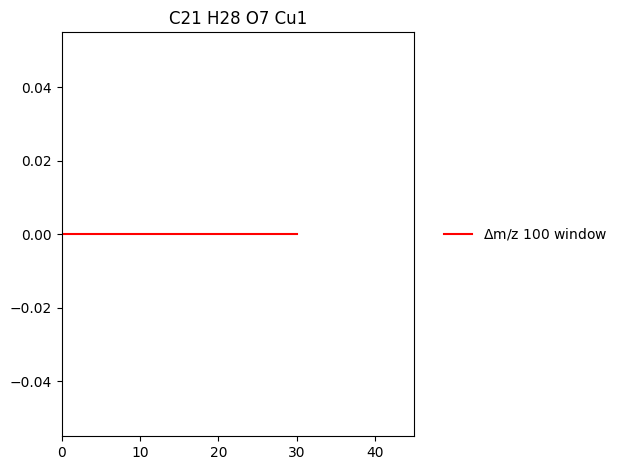

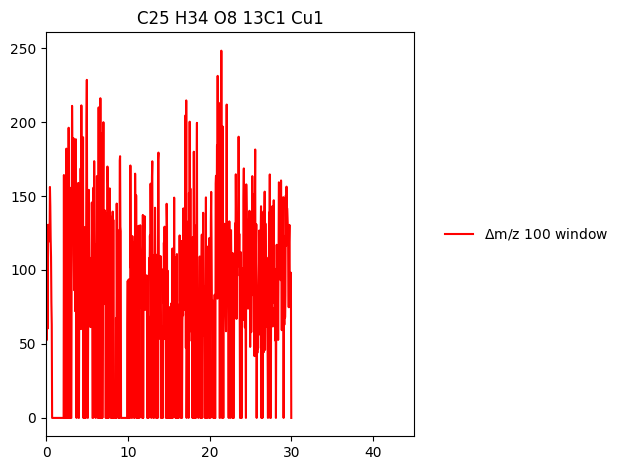

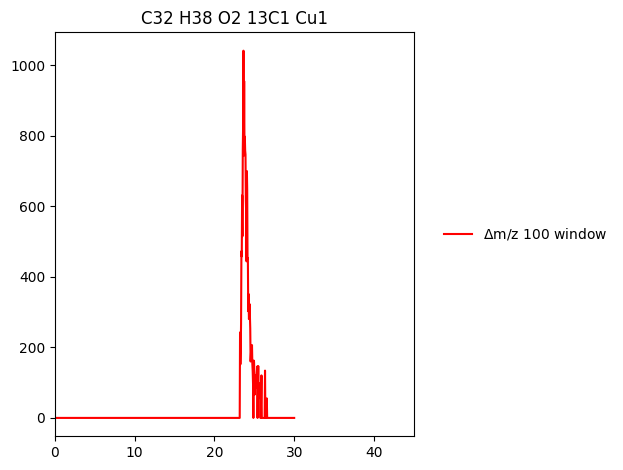

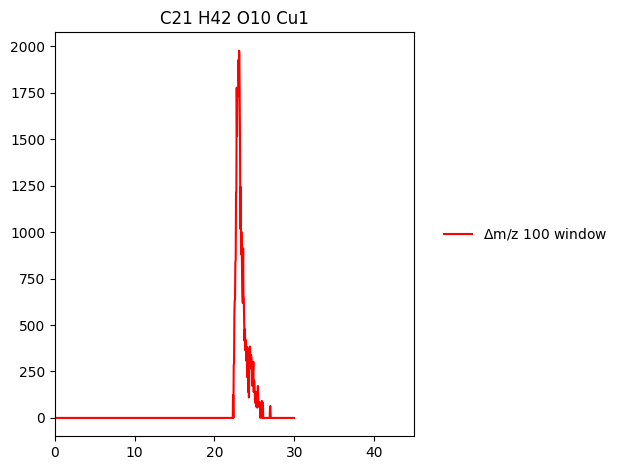

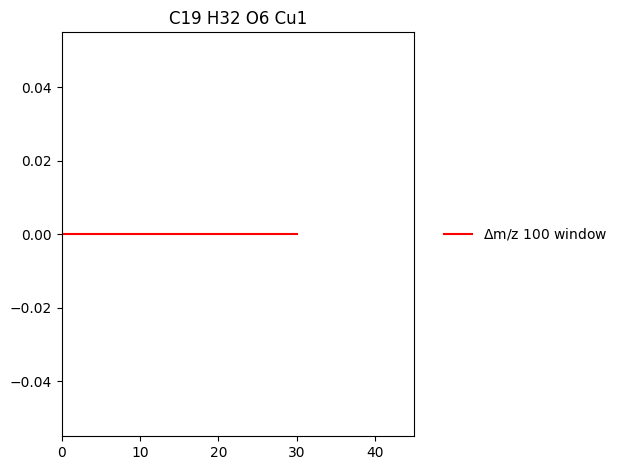

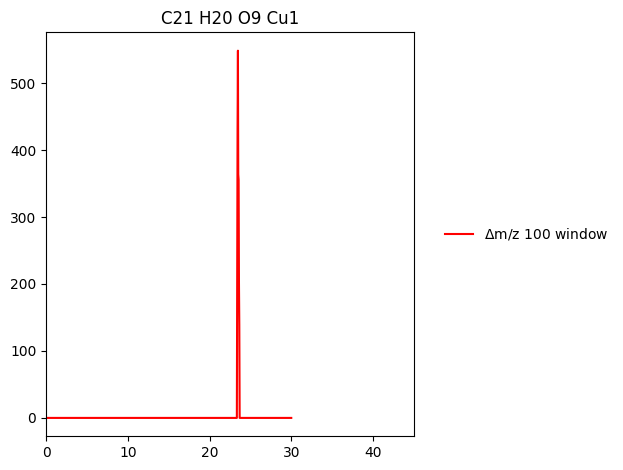

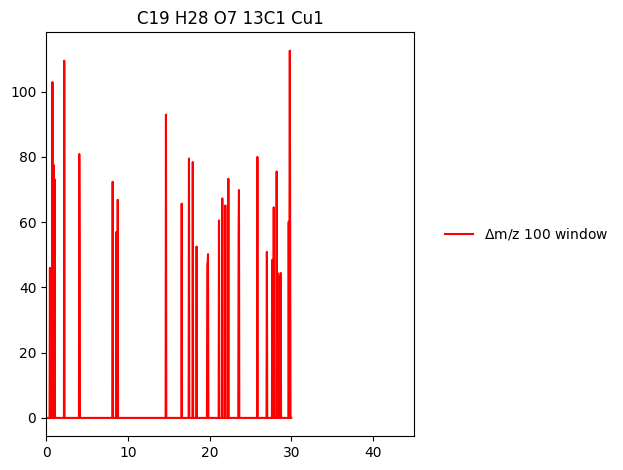

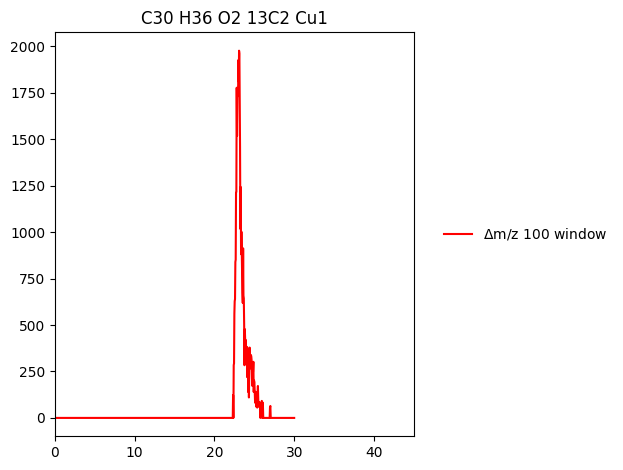

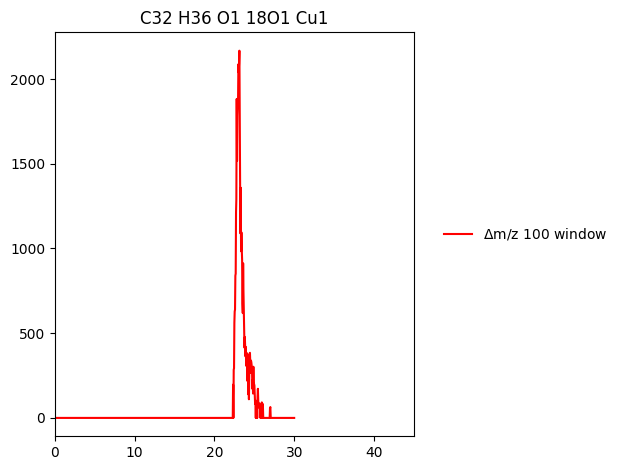

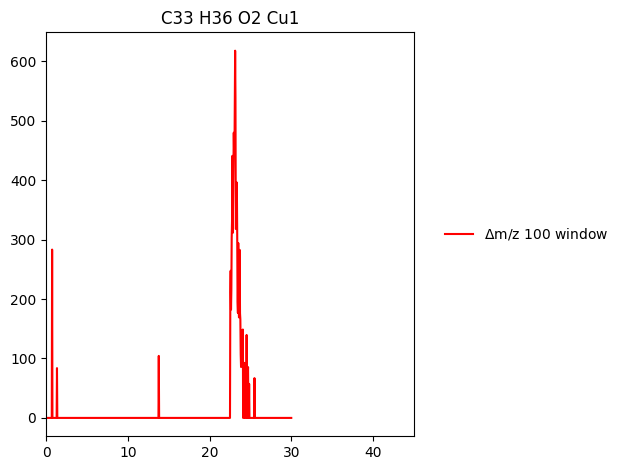

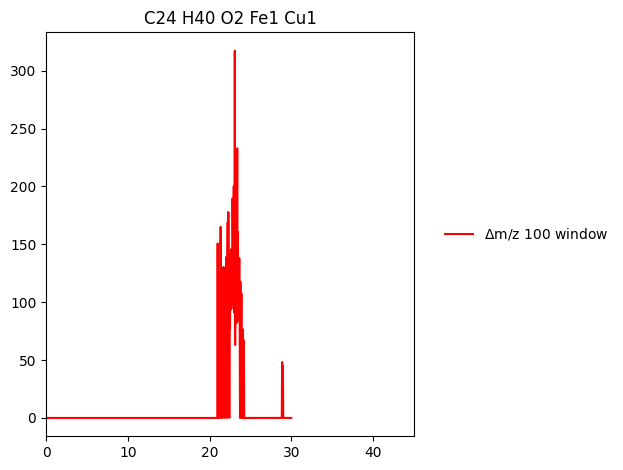

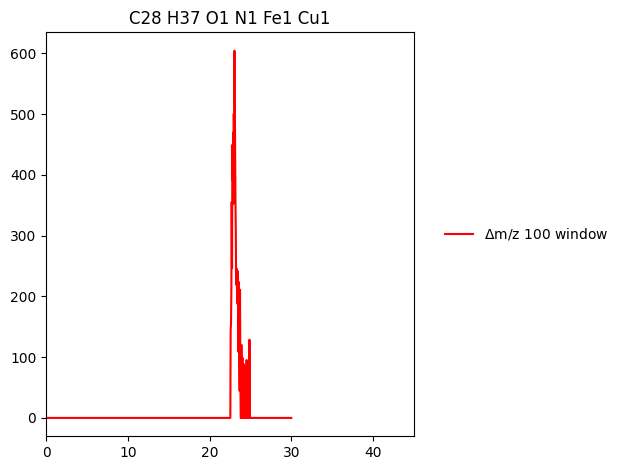

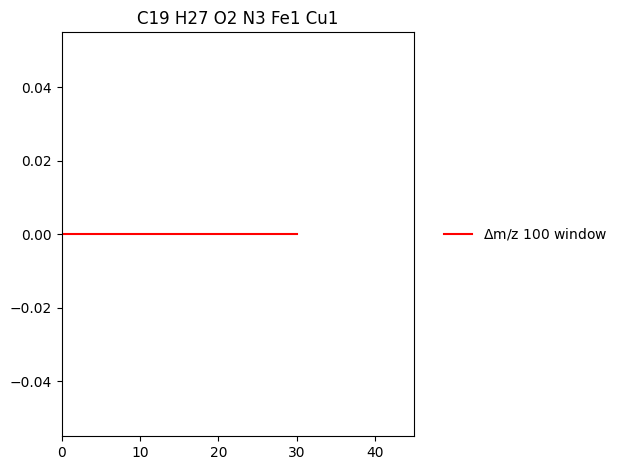

In [144]:
#ax.set_ylim(0,maxicp*1.1)

for mf in EICdic:   

    fig, ax = plt.subplots()
    
    eict=EICdic[mf].time
    eics=EICdic[mf].eic

    inds = np.where(np.asarray(eict)<30)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    ax.set_xlim(0,45)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()

    plt.show()

In [ ]:
# 200 m/z window, error plots with blanks removed 

df = lcmsfns.blankSubtract(unique_200mz, blnkthresh = 0.6)
print(np.shape(unique_200mz))
print(np.shape(df))

fig = lcmsfns.plotUnique(df,ps=10)
fig.suptitle('200 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()


(16967, 53)
(16518, 54)
[0 1 2 3]


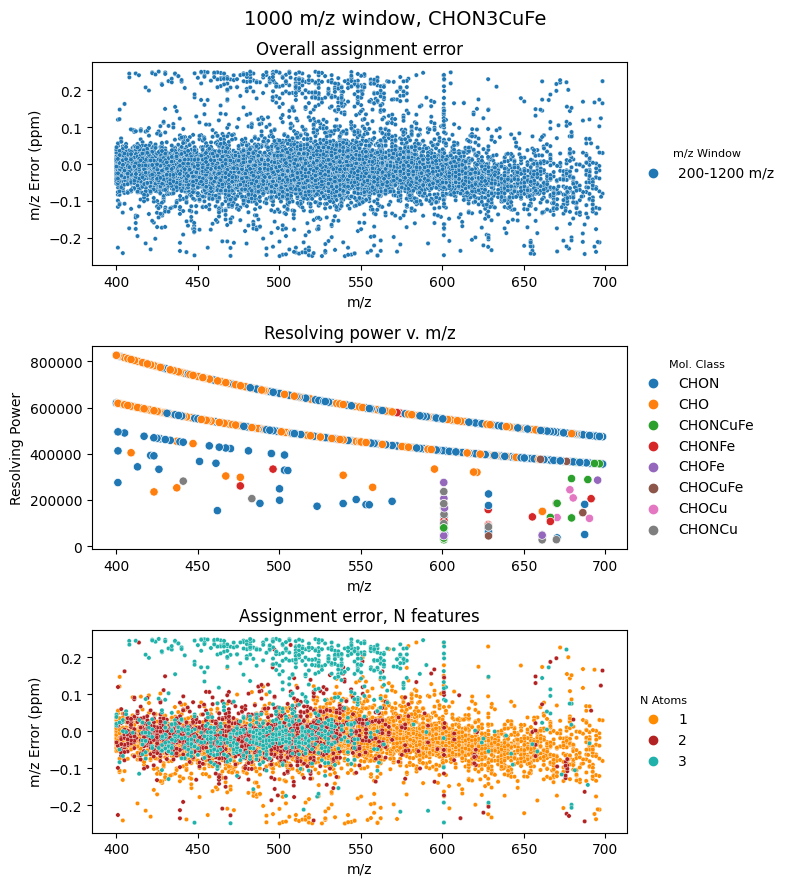

In [148]:
# full m/z window, error plots with blanks removed 

mask = ~unique_fullmz_456['file'].str.contains('qh2o', case=False, na=False)
unique_fullmz_nb=unique_fullmz_456[mask]
df = lcmsfns.blankSubtract(unique_fullmz_456, blnkthresh = 0.6)
print(np.shape(unique_fullmz_456))
print(np.shape(df))

fig = lcmsfns.plotUnique(df,ps=10)
fig.suptitle('1000 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()

In [ ]:
##### here 

temp = df_bs[abs(df_bs['m/z Error (ppm)'])<0.15]
print(np.shape(temp))
fig = lcmsfns.plotUnique(pd.concat([temp[temp['m/z window']== '400-500 m/z'], temp[temp['m/z window']=='500-600 m/z'], temp[temp['m/z window']=='400-600 m/z'], temp[temp['m/z window']=='200-1200 m/z']]),ps=5)

plt.tight_layout()
plt.show()
plt.close('all')

       Unnamed: 0.1  Unnamed: 0  Index         m/z  Calibrated m/z  \
0            426936         173    343  545.164832      545.165218   
3            426869         106    208  530.171041      530.171430   
4            426850          87    166  525.170434      525.170824   
14           426909         146    287  538.161730      538.162118   
17           426885         122    233  532.223086      532.223474   
...             ...         ...    ...         ...             ...   
23868        382272        3045    106  634.321593      634.321593   
23901        382267        3040     99  631.310700      631.310700   
25956        382228        3001     20  605.331555      605.331555   
25995        382220        2993      5  601.300282      601.300282   
26009        382224        2997     15  604.274809      604.274809   

       Calculated m/z  Peak Height  Peak Area  Resolving Power       S/N  ...  \
0          545.165353   171.673469  -0.241615    455078.626025  7.408746  ... 

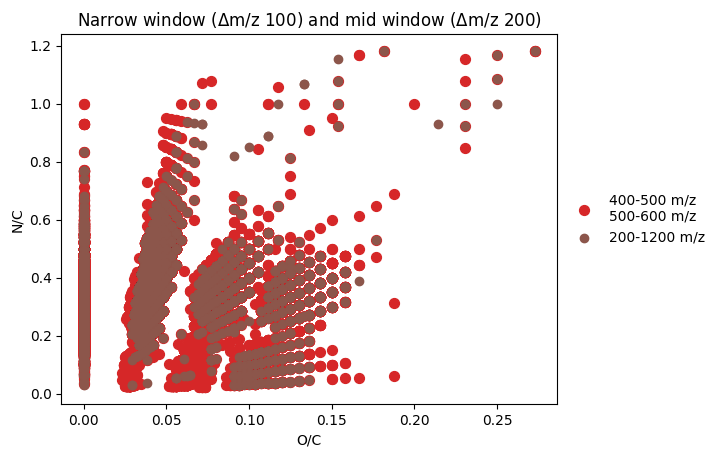

In [157]:

mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]
df = mz100_bs
print(df)

df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#sns.scatterplot(x='N/C',y='O/C', hue='m/z', data=df, ax=ax,s=50)
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()


In [ ]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#ax.scatter(x=df2['N/C'],y=df2['O/C'],c='black',s=5,label='400-600 m/z') #s=df2['S/N'],
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='black',s=5,label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and full window')
plt.show()


In [ ]:
mz100_contains_cu = mz100_bs[(mz100_bs['Cu'] == 1) ]
print(np.shape(mz100_contains_cu))


mz200_contains_cu = mz200_bs[(mz200_bs['Cu'] == 1) ]
print(np.shape(mz200_contains_cu))


mzfull_contains_cu = mzfull_bs[(mzfull_bs['Cu'] == 1)]
print(np.shape(mzfull_contains_cu))



In [ ]:
temp = temp[temp['Cu'] == 1]

temp['overlap'] = temp.Index

for i in range(len(temp['Molecular Formula'])):

    mf = temp['Molecular Formula'].iloc[i]

    if (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        temp['overlap'].iloc[i] = 'n'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nw'

    elif (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nm'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nmw'



In [ ]:
sns.jointplot(data=temp, x='N/C',y='O/C', hue='overlap')

In [ ]:
print(np.shape(mzfull_contains_cu))
print(np.shape(mz100_contains_cu))

combo_cu = pd.concat([mz100_contains_cu, mzfull_contains_cu])


In [ ]:

combo_cu['m/z Window Size'] = combo_cu.Index

for i in range(len(combo_cu['m/z window'])):

    w = combo_cu['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        combo_cu['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        combo_cu['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo_cu['m/z Window Size'].iloc[i] = '1000 m/z'

combo_cu['m/z Window Size'].unique()

In [ ]:
mz100_cu_limited_err.columns

In [ ]:
import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.02)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = .05)

d1=lcmsfns.normMS(mz100_cu_limited_err,mz100_cu_limited_err)
d2=lcmsfns.normMS(mzfull_cu_limited_err,mzfull_cu_limited_err)

ax1_b = plt.subplot(gs1[0])
ax1_b = lcmsfns.plot_ms(df1=d1,  df2=d2, start_mz=400, end_mz=600,ax_ms=ax1_b, norm=True)

sns.despine(ax=ax1_b)

ax1_b.set_ylim(bottom=0)





ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo_cu, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Features (count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

In [ ]:
combo = pd.concat([mz100_bs, mzfull_bs])

combo['m/z Window Size'] = combo.Index

for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

combo['m/z Window Size'].unique()

combo_n = combo[combo['N']>=1]

import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])

ax1 = plt.subplot(gs1[0])

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax1)
ax1.set_ylabel('Assigned Features\n(count)')
ax1.legend_.remove()
ax1.set_xlim(400,600)
sns.despine(ax=ax1)





ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo_cu, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Cu Features\n(count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

In [ ]:

print((np.shape(combo[combo['m/z Window Size']=='100 m/z'])[0] - np.shape(combo[combo['m/z Window Size']=='1000 m/z'])[0]) /  np.shape(combo[combo['m/z Window Size']=='1000 m/z'])[0])

print((np.shape(combo_cu[combo_cu['m/z Window Size']=='100 m/z'])[0] - np.shape(combo_cu[combo_cu['m/z Window Size']=='1000 m/z'])[0]) / np.shape(combo_cu[combo_cu['m/z Window Size']=='1000 m/z'])[0])

In [ ]:
#data.master_data_holder['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'] #[file]={'parser': parser}
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.25]
mz100_EICdic = {}
for mz,file,mf in zip(mz100_cu_limited_err['m/z'],mz100_cu_limited_err['file'],mz100_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']    
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    mz100_EICdic[mf]=EIC[0][mz]
    #mz100_EICdic[mz]={'eic':EIC[0][mz],'formula':mf}


In [ ]:
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.25]
fullmz_EICdic = {}
for mz,file,mf in zip(mzfull_cu_limited_err['m/z'],mzfull_cu_limited_err['file'],mzfull_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    fullmz_EICdic[mf]=EIC[0][mz]

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_ENV.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu', '115In']

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec13.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()

In [ ]:
# C23 H32 O3 Cu

sub = combo[combo['Molecular Formula'] == 'C23 H32 O3 Cu1']

sub

In [ ]:
for i in range(len(mz100_cu_limited_err.index)):

    mf = mz100_cu_limited_err['Molecular Formula'].iloc[i]
    
    if mf in mzfull_cu_limited_err['Molecular Formula'].values:

        print('\n\nNarrow m/z:')
        print(mz100_cu_limited_err.iloc[i,:])

        ind = mzfull_cu_limited_err[mzfull_cu_limited_err['Molecular Formula'] == mf].index 
        print('\nFull m/z:')
        print(mzfull_cu_limited_err.loc[ind].squeeze())




In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec5.pdf')


for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()

In [ ]:
refs = pd.read_csv('/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref')
#r45 = refs[(refs['m/z value']>=400) & (refs['m/z value']<=500)]

print(refs[' m/z value'])


In [ ]:
import math
#assigned_100mz
#assigned_200mz
#assigned_fullmz[assigned_fullmz['13C'] == 1]
test1 = []
test2 = []
for i in range(len(unique_fullmz[unique_fullmz['13C'] == 1].index)):
    
    r13c = unique_fullmz[unique_fullmz['13C'] == 1].iloc[i]
    mf13c = r13c['Molecular Formula']
    iso_sim = r13c['Isotopologue Similarity']
    
    mono_index = int(r13c['Mono Isotopic Index'])

    r13c.fillna(0,inplace=True)
    nC = int(r13c['C'])
    n13C = int(r13c['13C'])
    nH = int(r13c['H'])
    nO = int(r13c['O'])
    nN = int(r13c['N'])

    if (nO > 0) and (~math.isnan(nO)):
        mf_t = 'C%s H%s O%s' %((nC + n13C),nH,nO)
    elif (nN > 0) and (~math.isnan(nN)):
        mf_t = 'C%s H%s O%s N%s' %((nC + n13C),nH,nO, nN)
    else:
        mf_t = 'C%s H%s' %((nC + n13C),nH)

   # print('\n',mf_t)
    if mf_t in unique_fullmz['Molecular Formula']:
        print('yyy')
        print(unique_fullmz[unique_fullmz['Molecular Formula'] == mf_t])
    #mf12c = unique_fullmz[unique_fullmz['Isotopologue Similarity']==iso_sim]['Molecular Formula']

    #temp2 = mf12c.values
    #print('\ntemp2')
    #print(temp2)
    #for i in range(len(temp2)):
    #    test2.append(temp2[i])

    mf12c_in = unique_fullmz[unique_fullmz['Index']==mono_index]
    best_match = mf12c_in[mf12c_in['Isotopologue Similarity']==iso_sim]['Molecular Formula']

    temp=best_match.values
    print('temp')
    print(mf13c,mono_index,temp)
    for i in range(len(temp)):
        test1.append(temp[i])


#print('\n', mf13c,'\n',best_match)

print(len(test1))

In [ ]:
mono_indices = []
iso_indices = []
for i in unique_fullmz[unique_fullmz['13C'] == 1].index:

    r13c = unique_fullmz.loc[i]

    mf13c = r13c['Molecular Formula']
    iso_sim = r13c['Isotopologue Similarity']    
    mono_index = int(r13c['Mono Isotopic Index'])

    mf12c_in = unique_fullmz[unique_fullmz['Index']==mono_index]
    best_match = mf12c_in[mf12c_in['Isotopologue Similarity']==iso_sim].index

    if len(best_match.values) > 0:
        
        mono_indices.append(best_match.values[0])

        iso_indices.append(i)

print(len(mono_indices),len(iso_indices))

In [ ]:
df = assigned_fullmz[assigned_fullmz['file'] == '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw']
df = assigned_100mz_456[assigned_fullmz['file'] == '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw']

intensity_v_ratio = []

for t in df['Time'].unique():

    print(t)

    time_sub = df[df['Time'] == t]

    time_sub['13C'].fillna(0)
   # print(time_sub['Index'])
    if 1.0 in time_sub['13C'].values:

        for i in time_sub[time_sub['13C'] == 1].index:

            iso_row = time_sub.loc[i]

            #print(iso_row)

            mf_13C = iso_row['Molecular Formula']
            mono_index = int(iso_row['Mono Isotopic Index'])
            mf_12C = time_sub[time_sub['Index']==mono_index]['Molecular Formula']
            nC =  time_sub[time_sub['Index']==mono_index]['C'].iloc[0]
            #print(mf_13C, mono_index, mf_12C)

            int_13C = iso_row['Peak Height']
            mz_13C = iso_row['Calibrated m/z']
            int_12C =  time_sub[time_sub['Index']==mono_index]['Peak Height'].iloc[0]
            mz_12C =  time_sub[time_sub['Index']==mono_index]['Calibrated m/z'].iloc[0]
            print(int_12C, int_13C, nC, mz_12C, mz_13C)
            intensity_v_ratio.append([int_12C, int_13C, nC, mz_12C, mz_13C])







In [ ]:
df = np.asarray(intensity_v_ratio)
np.shape(df)
df1 = df #[df[:,0]<1e5]

pddf = pd.DataFrame(df1,columns=['12C Intensity','13C Intensity','nC', 'm/z 12C', 'm/z 13C'])


In [ ]:
import scipy

df1 = df[df[:,0]<1e5]
logx = np.log10(df1[:,0])
logy = np.log10(df1[:,2])

logyerr = np.std(df1[:,1]) / df1[:,2]

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = scipy.optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

In [ ]:
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

nn = 1e4
df1 = df[df[:,0]<nn]

xData = df1[:,0]
yData = df1[:,1]

xmin = min(xData)
print(xmin)
def func(x, a,  b, c, d): # Sigmoid A With Offset from zunzun.com
    #return a*(x-d)**3 + b*(x-d)**2 + c*x 
    return a*np.exp(b/((x-800)))
    return a*(x-d)**5 + b*(x-d)**2 + c*(x-d)

def func2(x, a,  b, c, d): # Sigmoid A With Offset from zunzun.com
    #return a*(x-d)**3 + b*(x-d)**2 + c*x 
    return a*np.exp((b-x)/((x)))
    return a*(x-d)**5 + b*(x-d)**2 + c*(x-d)

# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return np.sum((yData - val) ** 2.0)



# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData)
fittedParameters2, pcov2 = curve_fit(func2, xData, yData)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)



##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(df[:,0], df[:,1],  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(1000, nn, int(1e6))
    yModel = func(xModel, *fittedParameters)

    xModel2 = np.linspace(1000, nn, int(1e6))
    yModel2 = func2(xModel2, *fittedParameters2)
    # now the model as a line plot 
    axes.plot(xModel, yModel)

    axes.plot(xModel2, yModel2, color ='red')

    axes.set_xlim(0,1.1*nn)
    axes.set_ylim(0,1)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

In [ ]:


fig, ax = plt.subplots()

ax.scatter(pddf['12C Intensity'], pddf['12C Intensity']/pddf['13C Intensity']/pddf['nC'])

#ax.errorbar(df1[:,0], df1[:,1], yerr=np.std(df1[:,1]), fmt='k.')  # Data

ax.set_ylim(0,1)

ax.set_xlim(0,1.1e4)
plt.show()

In [ ]:


xx = np.linspace(1, int(5e5), int(1e4))
yy = np.linspace(1, int(5e5), int(1e4))


fig, ax = plt.subplots()

#ax.scatter((pddf['nC']*1.1/100*pddf['12C Intensity']),(pddf['13C Intensity']-(pddf['nC']*1.1/100*pddf['12C Intensity']))/(pddf['nC']*1.1/100*pddf['12C Intensity']))
ax.scatter((pddf['nC']*1.1/100*pddf['12C Intensity']),pddf['13C Intensity'])
#ax.scatter((pddf['nC']*pddf['12C Intensity']),pddf['13C Intensity'])

ax.scatter(xx, yy, color='orange',s=1)

ax.set_xlim(0,10e4)
ax.set_ylim(0,10e4)
ax.plot

plt.show()

In [ ]:
def func2(x, a,  b, c): # Sigmoid A With Offset from zunzun.com
    return 1 - b/((x)**0.5)


yy = (pddf['nC']*1.07/100*pddf['12C Intensity'])
xx = pddf['12C Intensity']

fittedParameters2, pcov2 = curve_fit(func2, xx,  pddf['13C Intensity']/yy)

print(fittedParameters2)
fig, ax = plt.subplots()

ax.scatter(pddf['12C Intensity'], pddf['13C Intensity']/yy,s=1)


xModel2 = np.linspace(1000, 1e6, int(1e6))
yModel2 = func2(xModel2, *fittedParameters2)
# now the model as a line plot 
ax.plot(xModel2, yModel2)

ax.plot(xModel2, yModel2, color ='red')

ax.set_xlim(0,0.5e6)
ax.set_ylim(0,1.05)

xlabels = ['{:,.0f}'.format(x) for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)

ax.set_xlabel(r'Intensity $^{12}$C$_{M}$' + ' (1000s cps)') #'Monoisotopic intensity (1000s cps)')
ax.set_ylabel(r'Intensity $^{13}$C$_{M}$ / Intensity $^{13}$C$_{T}$')
#ax.set_ylabel(r'$\frac{{{%s}}}{%s}$' %(nom,den))

plt.show()

In [ ]:
df_cu = mz100_contains_cu
df_cu['13C'] = df_cu['13C'].fillna(0)
df_cu_mono = df_cu[df_cu['13C']==0]

print(np.shape(df_cu))
print(np.shape(df_cu_mono))

df_cu_mono['Theoretical 65Cu Peak Height'] = df_cu_mono['Peak Height']*.3083

#69.17 and 30.83% 63Cu 65Cu

for i, j in zip(df_cu_mono['Peak Height'], df_cu_mono['Theoretical 65Cu Peak Height']):
    iso_ph = df_cu_mono['C'].iloc[0]*1.1/100*i
    print(i,j, iso_ph)

